# TFM_XAI_PD

# Explicabilidad en modelos de Machine Learning para la probabilidad de default.

## Librerias y ruta principal

In [3]:
# Importación de Librerías

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
import shap
import lime.lime_tabular
import re
from itertools import combinations
from PIL import Image
import os
import textwrap
import matplotlib.pyplot as plt

In [4]:
# Ruta donde dejar toda la info
Ruta=r'C:\Users\carol\OneDrive\TFM\pyhton\\'

## Determinación de la probabilidad de default a partir del ratio de morosidad

In [6]:
# Creditos
Creditos = pd.read_excel(Ruta+'Creditos.xlsx',sheet_name='Bcos. Priv.',skiprows=10)
Creditos=Creditos.iloc[:,[0,25,26,27,35,36,37]]
nueva_columna=['Fecha','MONEDA_NACIONAL_vigente','MONEDA_NACIONAL_vencido','Total_MONEDA_NACIONAL',
               'MONEDA_EXTRANJERA_vigente','MONEDA_EXTRANJERA_vencido','Total_MONEDA_EXTRANJERA']
Creditos.columns=nueva_columna
Creditos['Fecha']=pd.to_datetime(Creditos['Fecha'],errors='coerce')
Creditos['Fecha'] = Creditos['Fecha'].dt.to_period('M').dt.to_timestamp()
Creditos['Morosidad_MN']=Creditos['MONEDA_NACIONAL_vencido']/Creditos['Total_MONEDA_NACIONAL']*100
Creditos['Morosidad_ME']=Creditos['MONEDA_EXTRANJERA_vencido']/Creditos['Total_MONEDA_EXTRANJERA']*100
Creditos=Creditos.sort_values(by='Fecha',ascending=False).reset_index(drop=True).ffill()
Creditos.set_index('Fecha',inplace=True)
Creditos.to_excel(Ruta+'Creditos final para chequear.xlsx')
Creditos

,MONEDA_NACIONAL_vigente,MONEDA_NACIONAL_vencido,Total_MONEDA_NACIONAL,MONEDA_EXTRANJERA_vigente,MONEDA_EXTRANJERA_vencido,Total_MONEDA_EXTRANJERA,Morosidad_MN,Morosidad_ME
Fecha,,,,,,,,
2025-09-01,296430.475882,8700.608160,305131.084043,9130.388605,62.508486,9192.897091,2.851433,0.679965
2025-08-01,293463.894403,8255.141173,301719.035576,9012.901868,56.462581,9069.364449,2.736036,0.622564
2025-07-01,290484.881504,9137.450993,299622.332497,8900.697319,56.309181,8957.006501,3.049656,0.628661
2025-06-01,290434.450934,8885.534379,299319.985313,8912.677603,56.204218,8968.881821,2.968574,0.626658
2025-05-01,286639.299482,8489.929421,295129.228903,8980.692426,55.038799,9035.731225,2.876682,0.609124
...,...,...,...,...,...,...,...,...
1999-01-01,7295.050000,998.270000,8304.290000,3157.000000,294.000000,3451.000000,12.021136,8.519270
1999-01-01,7295.050000,998.270000,8304.290000,3157.000000,294.000000,3451.000000,12.021136,8.519270
1999-01-01,7295.050000,998.270000,8304.290000,3157.000000,294.000000,3451.000000,12.021136,8.519270


In [7]:
Var_dep=Creditos.reset_index()
Var_dep=Var_dep[['Fecha','Morosidad_MN','Morosidad_ME']]
Var_dep

,Fecha,Morosidad_MN,Morosidad_ME
0,2025-09-01,2.851433,0.679965
1,2025-08-01,2.736036,0.622564
2,2025-07-01,3.049656,0.628661
3,2025-06-01,2.968574,0.626658
4,2025-05-01,2.876682,0.609124
...,...,...,...
328,1999-01-01,12.021136,8.519270
329,1999-01-01,12.021136,8.519270
330,1999-01-01,12.021136,8.519270
331,1999-01-01,12.021136,8.519270


## Factores macroeconomicos

In [9]:
#Inflación (IF)
IF = pd.read_excel(Ruta+'IPC gral y variaciones.xlsx',skiprows=7)
#Renombra las columnas
IF = IF.rename(columns={
    'Mes y año': 'Fecha',
    'Índice': 'IF',
    'Acum. año': 'IF_a'
})

# Selecciona columnas
IF = IF[['Fecha', 'IF', 'IF_a']]

# Elimina filas totalmente vacías (evita NaT posteriores)
IF = IF.dropna(how='all')

# Interpreta fechas
IF['Fecha'] = pd.to_datetime(IF['Fecha'], errors='coerce')

# Elimina filas donde la fecha no pudo interpretarse (evita NaT)
IF = IF.dropna(subset=['Fecha'])

# Fija la fecha al primer día del mes
IF['Fecha'] = IF['Fecha'].dt.to_period('M').dt.to_timestamp('D')

# Indexa
IF = IF.set_index('Fecha').sort_index()

# Asegura que no queden valores NaN extra 
IF = IF.dropna()
IF

,IF,IF_a
Fecha,,
1938-01-01,1.619640e-07,0.311526
1938-02-01,1.559281e-07,-3.426791
1938-03-01,1.554251e-07,-3.738318
1938-04-01,1.554251e-07,-3.738318
1938-05-01,1.594491e-07,-1.246106
...,...,...
2025-06-01,1.133059e+02,2.732435
2025-07-01,1.133672e+02,2.788039
2025-08-01,1.133291e+02,2.753457


In [10]:
#Tasa de interés activa en dólares (T_ME)
T_ME = pd.read_excel(Ruta+'tasas.xlsx',sheet_name='Activas U$S',skiprows=12)
T_ME = T_ME.iloc[:, [1, 2]]
T_ME.columns = ['Fecha', 'TME']

# Convierte fechas y descarta filas inválidas
T_ME['Fecha'] = pd.to_datetime(T_ME['Fecha'], errors='coerce')
T_ME = T_ME.dropna(subset=['Fecha'])

# Fija Fecha al primer día del mes
T_ME['Fecha'] = T_ME['Fecha'].dt.to_period('M').dt.to_timestamp('D')

# Indexa como serie mensual ordenada
T_ME = T_ME.set_index('Fecha').sort_index()

T_ME['TME_m'] = T_ME['TME'].diff(1)
T_ME=T_ME.dropna()
# Resultado final
T_ME

,TME,TME_m
Fecha,,
1998-03-01,12.885000,0.648968
1998-04-01,12.313246,-0.571753
1998-05-01,12.119467,-0.193779
1998-06-01,12.013695,-0.105772
1998-07-01,11.881066,-0.132628
...,...,...
2025-05-01,5.497730,-0.174549
2025-06-01,5.484474,-0.013256
2025-07-01,5.518045,0.033571


In [11]:
#Tasa de interés activa en pesos (T_MN)
T_MN = pd.read_excel(Ruta+'tasas.xlsx',sheet_name='Activas $',skiprows=12)
T_MN = T_MN.iloc[:, [1, 2]]
T_MN.columns = ['Fecha', 'TMN']

# Convierte fechas y elimina filas inválidas
T_MN['Fecha'] = pd.to_datetime(T_MN['Fecha'], errors='coerce')
T_MN = T_MN.dropna(subset=['Fecha'])

# Fija Fecha al primer día del mes
T_MN['Fecha'] = T_MN['Fecha'].dt.to_period('M').dt.to_timestamp('D')

# Indexa y ordena
T_MN = T_MN.set_index('Fecha').sort_index()

# Variación a 3 meses (periodicidad mensual → diff(3))
T_MN['TMN_m'] = T_MN['TMN'].diff(1)

# Resultado final
T_MN

,TMN,TMN_m
Fecha,,
1998-02-01,46.621665,NaN
1998-03-01,45.782279,-0.839386
1998-04-01,48.283652,2.501372
1998-05-01,46.648340,-1.635312
1998-06-01,44.194289,-2.454050
...,...,...
2025-05-01,15.825642,0.514904
2025-06-01,16.723779,0.898137
2025-07-01,16.786931,0.063152


In [12]:
# Tipo de cambio (TC)
TC = pd.read_excel(Ruta+'HistoricoDiario.xlsx')
TC = TC[['FECHA', 'CIERRE BCU FONDO']]

# Renombrar a TC
TC = TC.rename(columns={'FECHA': 'Fecha', 'CIERRE BCU FONDO': 'TC'})

# Convertir fechas
TC['Fecha'] = pd.to_datetime(TC['Fecha'], errors='coerce')
TC = TC.dropna(subset=['Fecha'])

# Convertir TC a numérico
TC['TC'] = pd.to_numeric(TC['TC'], errors='coerce')
TC = TC.dropna(subset=['TC'])

# Indexar por fecha diaria
TC = TC.set_index('Fecha').sort_index()

# --- Primer valor disponible del mes ---
TC = TC.resample('MS').first()

# --- Variaciones ---
TC['TC_m'] = TC['TC'].pct_change(1)
TC['TC_mlog'] = np.log(TC['TC']).diff(1)

# --- Resultado final solo con columnas limpias ---
TC = TC[['TC', 'TC_m', 'TC_mlog']]

TC=TC.dropna()
TC

,TC,TC_m,TC_mlog
Fecha,,,
1998-02-01,10.100,0.010505,0.010450
1998-03-01,10.160,0.005941,0.005923
1998-04-01,10.250,0.008858,0.008819
1998-05-01,10.320,0.006829,0.006806
1998-06-01,10.380,0.005814,0.005797
...,...,...,...
2025-07-01,40.046,-0.036985,-0.037687
2025-08-01,40.132,0.002148,0.002145
2025-09-01,40.007,-0.003115,-0.003120


In [13]:
# Tipo de cambio real(TCRE)
TCR = pd.read_excel(Ruta+'TCRE.xlsx',skiprows=9)
TCR.rename(columns=dict(zip(TCR.columns[:3], ['NA', 'Fecha', 'TCR'])), inplace=True)
TCR = TCR[['Fecha', 'TCR']]

# Convierte fechas y elimina filas inválidas
TCR['Fecha'] = pd.to_datetime(TCR['Fecha'], errors='coerce')
TCR = TCR.dropna(subset=['Fecha'])

# Fija Fecha al primer día del mes
TCR['Fecha'] = TCR['Fecha'].dt.to_period('M').dt.to_timestamp('D')

# Indexa y ordena como serie mensual
TCR = TCR.set_index('Fecha').sort_index()

# Variación mensual (frecuencia mensual → diff(1))
TCR['TCR_m'] = TCR['TCR'].pct_change(periods=1)

# Resultado final
TCR

,TCR,TCR_m
Fecha,,
2000-01-01,153.145497,NaN
2000-02-01,153.669855,0.003424
2000-03-01,154.642359,0.006329
2000-04-01,153.359663,-0.008295
2000-05-01,151.181421,-0.014203
...,...,...
2025-05-01,91.698229,0.003005
2025-06-01,90.787364,-0.009933
2025-07-01,88.855562,-0.021278


In [14]:
# Desempleo (DS)
DS=pd.read_excel(Ruta+'serie.xlsx')
DS['Fecha'] = DS['Mes']
DS = DS[['Fecha', 'Empleo', 'Desempleo', 'Actividad']]
DS = DS.rename(columns={
    'Fecha': 'Fecha',
    'Empleo': 'EM',
    'Desempleo': 'DS',
    'Actividad': 'AT'
})

# Convertir fechas
DS['Fecha'] = pd.to_datetime(DS['Fecha'], errors='coerce')
DS = DS.dropna(subset=['Fecha'])

# Fijar FECHA al primer día del mes
DS['Fecha'] = DS['Fecha'].dt.to_period('M').dt.to_timestamp('D')

# Indexar y ordenar
DS = DS.set_index('Fecha').sort_index()

# Variaciones a 3 meses (frecuencia mensual)
DS['DS_m'] = DS['DS'].diff(1)
DS['EM_mlog'] = np.log(DS['EM']).diff(1)
DS['AT_mlog'] = np.log(DS['AT']).diff(1)

# Resultado
DS=DS.dropna()
DS

,EM,DS,AT,DS_m,EM_mlog,AT_mlog
Fecha,,,,,,
1998-02-01,59.56,-9.362,68.560672,0.0,0.000000,8.881784e-16
1998-03-01,59.56,-9.362,68.560672,0.0,0.000000,0.000000e+00
1998-04-01,59.56,-9.362,68.560672,0.0,0.000000,0.000000e+00
1998-05-01,59.56,-9.362,68.560672,0.0,0.000000,0.000000e+00
1998-06-01,59.56,-9.362,68.560672,0.0,0.000000,-8.881784e-16
...,...,...,...,...,...,...
2025-01-01,59.40,-8.100,64.600000,-0.7,-0.006711,0.000000e+00
2025-02-01,59.40,-7.900,64.500000,0.2,0.000000,-1.549187e-03
2025-03-01,59.30,-8.000,64.500000,-0.1,-0.001685,0.000000e+00


In [15]:
# IMSR
ISR=pd.read_excel(Ruta+'ISR.xlsx',skiprows=9)
ISR.columns = ['Fecha', 'ISR', 'Privado', 'Publico']
ISR = ISR[['Fecha', 'ISR']]

# Convertir a fecha y estandarizar al 1er día del mes
ISR['Fecha'] = pd.to_datetime(ISR['Fecha'], errors='coerce')
ISR = ISR.dropna(subset=['Fecha'])
ISR['Fecha'] = ISR['Fecha'].dt.to_period('M').dt.to_timestamp('D')

# Indexar y ordenar
ISR = ISR.set_index('Fecha').sort_index()

# Asegurar frecuencia mensual (si hay huecos)
ISR = ISR.resample('MS').ffill()

# Variación mensual (en vez de trimestral)
ISR['ISR_m'] = ISR['ISR'].diff(1)

ISR=ISR.dropna()
ISR

,ISR,ISR_m
Fecha,,
1996-03-01,107.719799,0.039165
1996-04-01,107.246814,-0.472985
1996-05-01,108.289018,1.042203
1996-06-01,108.358237,0.069220
1996-07-01,108.229405,-0.128833
...,...,...
2025-05-01,144.730000,-0.060000
2025-06-01,144.850000,0.120000
2025-07-01,145.320000,0.470000


In [16]:
# Riesgo País (RP)
RP = pd.read_excel(Ruta+'IRUBEVSA.xlsx')
RP = RP[['FECHA', 'VALOR']]

# Convertir a fecha
RP['Fecha'] = pd.to_datetime(RP['FECHA'], errors='coerce')
RP = RP.dropna(subset=['Fecha'])

# Estandarizar al primer día del mes
RP['Mes'] = RP['Fecha'].dt.to_period('M')

# --- Eliminar duplicados por mes → conservar el último valor ---
RP = RP.sort_values('Fecha').groupby('Mes').tail(1)

# Crear columna Fecha como primer día del mes
RP['Fecha'] = RP['Mes'].dt.to_timestamp('D')

# Limpiar columnas
RP = RP[['Fecha', 'VALOR']].rename(columns={'VALOR': 'RP'})

# Indexar y ordenar
RP = RP.set_index('Fecha').sort_index()

# Ahora SÍ se puede resample sin error
RP = RP.resample('MS').ffill()

# Variación mensual
RP['RP_m'] = RP['RP'].pct_change(1)

RP

,RP,RP_m
Fecha,,
2015-08-01,247,NaN
2015-09-01,302,0.222672
2015-10-01,259,-0.142384
2015-11-01,260,0.003861
2015-12-01,258,-0.007692
...,...,...
2025-07-01,84,-0.142857
2025-08-01,89,0.059524
2025-09-01,76,-0.146067


In [17]:
# IVF (PBI) Desestacionalizado
IVF=pd.read_excel(Ruta+'IVF.xlsx',header=None)
columnas = IVF.iloc[7, 5:]
valores  = IVF.iloc[8, 5:]

# Crear DataFrame base
IVF = pd.DataFrame({
    "Periodo_raw": columnas.values,
    "IVF": valores.values
})

# Mapeo trimestre → mes final
trimestre_to_mes = {"I": "03", "II": "06", "III": "09", "IV": "12"}

def convertir_periodo(periodo):
    """Convierte 'III 2023*' → datetime(2023-09-01)"""
    partes = str(periodo).split()
    if len(partes) >= 2:
        tri = partes[0]               # I, II, III, IV
        anio = partes[1].replace("*", "")
        mes  = trimestre_to_mes.get(tri, "01")
        fecha = f"{anio}-{mes}-01"
        return pd.to_datetime(fecha, errors='coerce')
    return pd.NaT

# Convertir periodos trimestrales a fecha (primer día del mes final del trimestre)
IVF["Fecha"] = IVF["Periodo_raw"].apply(convertir_periodo)

# Mantener solo fecha + valor
IVF = IVF[["Fecha", "IVF"]].dropna()

# Indexar y ordenar
IVF = IVF.set_index("Fecha").sort_index()
IVF["IVF"] = pd.to_numeric(IVF["IVF"], errors="coerce")

# --- Interpolación mensual (primer día del mes) ---
IVF = IVF.resample("MS").interpolate(method="linear")

# Variación mensual (puede ser absoluta o normal)
IVF["IVF_m"] = IVF["IVF"].pct_change(1)

IVF=IVF.dropna()
IVF

,IVF,IVF_m
Fecha,,
2016-04-01,99.384783,0.003144
2016-05-01,99.696272,0.003134
2016-06-01,100.007761,0.003124
2016-07-01,99.951508,-0.000562
2016-08-01,99.895254,-0.000563
...,...,...
2025-02-01,111.118791,0.002263
2025-03-01,111.369654,0.002258
2025-04-01,111.518132,0.001333


In [18]:
# IMAE (indicador mensual de actividad economica)
IMAE=pd.read_excel(Ruta+'IMAE.xlsx')
IMAE = IMAE.rename(columns={
    'Fecha': 'Fecha',
    'IMAE': 'IMAE',
    'Desestacionalizado': 'IMAE_D',
    'Tendencia.Ciclo': 'IMAE_TC'
})

# Convertir a fecha
IMAE['Fecha'] = pd.to_datetime(IMAE['Fecha'], dayfirst=True, errors='coerce')
IMAE = IMAE.dropna(subset=['Fecha'])

# Ajustar FECHA al primer día del mes
IMAE['Fecha'] = IMAE['Fecha'].dt.to_period('M').dt.to_timestamp('D')

# Indexar y ordenar
IMAE = IMAE.set_index('Fecha').sort_index()

# --- Resample mensual primer día del mes ---
IMAE = IMAE.resample('MS').ffill()

# Variaciones mensuales
IMAE['IMAE_m'] = IMAE['IMAE'].diff(1)
IMAE['IMAE_Dm'] = IMAE['IMAE_D'].diff(1)
IMAE['IMAE_TCm'] = IMAE['IMAE_TC'].diff(1)

IMAE

,IMAE,IMAE_D,IMAE_TC,IMAE_m,IMAE_Dm,IMAE_TCm
Fecha,,,,,,
2016-01-01,96.090,95.932,98.855,NaN,NaN,NaN
2016-02-01,97.932,100.827,99.162,1.842,4.895,0.307
2016-03-01,97.434,100.533,99.422,-0.498,-0.294,0.260
2016-04-01,97.357,99.747,99.654,-0.077,-0.786,0.232
2016-05-01,103.059,99.776,99.805,5.702,0.029,0.151
...,...,...,...,...,...,...
2025-04-01,110.991,112.623,111.334,4.397,1.504,0.159
2025-05-01,116.974,112.220,111.369,5.983,-0.403,0.035
2025-06-01,112.753,110.684,111.292,-4.221,-1.536,-0.077


## Variables independientes (consolidacion y selección)

In [20]:
# Consolidación variables independientes
IND=pd.concat([IF,T_MN,T_ME,TC,TCR,DS,ISR
                # ,IMAE,IVF,RP
              ],axis=1,join='inner')
IND=IND.sort_index()
IND['ISR_usd'] = IND['ISR'] / IND['TC']
IND.to_excel(Ruta+'Base.xlsx')
IND

,IF,IF_a,TMN,TMN_m,TME,TME_m,TC,TC_m,TC_mlog,TCR,TCR_m,EM,DS,AT,DS_m,EM_mlog,AT_mlog,ISR,ISR_m,ISR_usd
Fecha,,,,,,,,,,,,,,,,,,,,
2000-01-01,15.803728,0.378574,43.088958,-0.263577,12.336204,0.134981,11.620,0.005190,0.005177,153.145497,NaN,57.7825,-11.726583,66.514557,-0.180083,0.000649,0.000649,111.827103,0.361453,9.623675
2000-02-01,15.856991,0.716875,43.739896,0.650938,12.256286,-0.079919,11.680,0.005164,0.005150,153.669855,0.003424,57.8200,-11.906667,66.557724,-0.180083,0.000649,0.000649,111.433757,-0.393346,9.540561
2000-03-01,15.954638,1.337092,40.721037,-3.018859,12.382459,0.126173,11.760,0.006849,0.006826,154.642359,0.006329,57.8575,-12.086750,66.600891,-0.180083,0.000648,0.000648,111.114828,-0.318929,9.448540
2000-04-01,16.024387,1.780105,41.971303,1.250267,12.609602,0.227143,11.840,0.006803,0.006780,153.359663,-0.008295,57.8950,-12.266833,66.644058,-0.180083,0.000648,0.000648,110.997888,-0.116941,9.374822
2000-05-01,16.097940,2.247282,39.363354,-2.607949,12.934370,0.324768,11.890,0.004223,0.004214,151.181421,-0.014203,57.9325,-12.446917,66.687225,-0.180083,0.000648,0.000648,110.880947,-0.116941,9.325563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01,111.508996,1.103218,16.893047,-0.611456,5.682220,0.005253,43.900,0.016604,0.016467,93.341562,-0.016749,59.4000,-8.100000,64.600000,-0.700000,-0.006711,0.000000,146.170000,4.010000,3.329613
2025-02-01,112.279909,1.802191,17.322901,0.429855,5.629482,-0.052738,43.495,-0.009226,-0.009268,92.863683,-0.005120,59.4000,-7.900000,64.500000,0.200000,0.000000,-0.001549,145.410000,-0.760000,3.343143
2025-03-01,112.917499,2.380283,15.913999,-1.408902,5.644578,0.015095,42.594,-0.020715,-0.020933,91.230952,-0.017582,59.3000,-8.000000,64.500000,-0.100000,-0.001685,0.000000,144.650000,-0.760000,3.396018


In [21]:
import statsmodels.api as sm

# --- 1. Crear rezagos de 6 meses para TODAS las variables de IND ---
rezagos = range(1, 7)  # 1 a 6 meses

IND_LAG = IND.copy()

for col in IND.columns:
    for lag in rezagos:
        IND_LAG[f"{col}_lag{lag}"] = IND[col].shift(lag)
IND_LAG 


C:\Users\carol\AppData\Local\Temp\ipykernel_31188\2139101447.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IND_LAG[f"{col}_lag{lag}"] = IND[col].shift(lag)
C:\Users\carol\AppData\Local\Temp\ipykernel_31188\2139101447.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IND_LAG[f"{col}_lag{lag}"] = IND[col].shift(lag)
C:\Users\carol\AppData\Local\Temp\ipykernel_31188\2139101447.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

,IF,IF_a,TMN,TMN_m,TME,TME_m,TC,TC_m,TC_mlog,TCR,...,ISR_m_lag3,ISR_m_lag4,ISR_m_lag5,ISR_m_lag6,ISR_usd_lag1,ISR_usd_lag2,ISR_usd_lag3,ISR_usd_lag4,ISR_usd_lag5,ISR_usd_lag6
Fecha,,,,,,,,,,,,,,,,,,,,,
2000-01-01,15.803728,0.378574,43.088958,-0.263577,12.336204,0.134981,11.620,0.005190,0.005177,153.145497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,15.856991,0.716875,43.739896,0.650938,12.256286,-0.079919,11.680,0.005164,0.005150,153.669855,...,NaN,NaN,NaN,NaN,9.623675,NaN,NaN,NaN,NaN,NaN
2000-03-01,15.954638,1.337092,40.721037,-3.018859,12.382459,0.126173,11.760,0.006849,0.006826,154.642359,...,NaN,NaN,NaN,NaN,9.540561,9.623675,NaN,NaN,NaN,NaN
2000-04-01,16.024387,1.780105,41.971303,1.250267,12.609602,0.227143,11.840,0.006803,0.006780,153.359663,...,0.361453,NaN,NaN,NaN,9.448540,9.540561,9.623675,NaN,NaN,NaN
2000-05-01,16.097940,2.247282,39.363354,-2.607949,12.934370,0.324768,11.890,0.004223,0.004214,151.181421,...,-0.393346,0.361453,NaN,NaN,9.374822,9.448540,9.540561,9.623675,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01,111.508996,1.103218,16.893047,-0.611456,5.682220,0.005253,43.900,0.016604,0.016467,93.341562,...,-0.360000,-0.440000,-0.28,1.14,3.292036,3.424223,3.412043,3.555440,3.561763,3.597322
2025-02-01,112.279909,1.802191,17.322901,0.429855,5.629482,-0.052738,43.495,-0.009226,-0.009268,92.863683,...,-0.500000,-0.360000,-0.44,-0.28,3.329613,3.292036,3.424223,3.412043,3.555440,3.561763
2025-03-01,112.917499,2.380283,15.913999,-1.408902,5.644578,0.015095,42.594,-0.020715,-0.020933,91.230952,...,-0.250000,-0.500000,-0.36,-0.44,3.343143,3.329613,3.292036,3.424223,3.412043,3.555440


In [22]:
Creditos_MN = Creditos['Morosidad_MN']
Creditos_MN = Creditos_MN[~Creditos_MN.index.duplicated(keep='last')]
Creditos_MN=Creditos_MN.reset_index()
Creditos_MN

,Fecha,Morosidad_MN
0,2025-09-01,2.851433
1,2025-08-01,2.736036
2,2025-07-01,3.049656
3,2025-06-01,2.968574
4,2025-05-01,2.876682
...,...,...
316,1999-05-01,9.896603
317,1999-04-01,9.895052
318,1999-03-01,11.857143
319,1999-02-01,14.859438


In [23]:
IND_LAG = IND_LAG.reset_index()

In [24]:
# --- 2. Unir con la variable dependiente ---
df = pd.merge(
    Creditos_MN,
    IND_LAG,
    on='Fecha',
    how='inner'
).dropna()
df

,Fecha,Morosidad_MN,IF,IF_a,TMN,TMN_m,TME,TME_m,TC,TC_m,...,ISR_m_lag3,ISR_m_lag4,ISR_m_lag5,ISR_m_lag6,ISR_usd_lag1,ISR_usd_lag2,ISR_usd_lag3,ISR_usd_lag4,ISR_usd_lag5,ISR_usd_lag6
0,2025-05-01,2.876682,113.405890,2.823098,15.825642,0.514904,5.497730,-0.174549,41.933,-0.006939,...,-0.760000,4.010000,-0.250000,-0.500000,3.428930,3.396018,3.343143,3.329613,3.292036,3.424223
1,2025-04-01,2.756143,113.283709,2.712319,15.310738,-0.603261,5.672280,0.027702,42.226,-0.008640,...,4.010000,-0.250000,-0.500000,-0.360000,3.396018,3.343143,3.329613,3.292036,3.424223,3.412043
2,2025-03-01,2.605110,112.917499,2.380283,15.913999,-1.408902,5.644578,0.015095,42.594,-0.020715,...,-0.250000,-0.500000,-0.360000,-0.440000,3.343143,3.329613,3.292036,3.424223,3.412043,3.555440
3,2025-02-01,2.752916,112.279909,1.802191,17.322901,0.429855,5.629482,-0.052738,43.495,-0.009226,...,-0.500000,-0.360000,-0.440000,-0.280000,3.329613,3.292036,3.424223,3.412043,3.555440,3.561763
4,2025-01-01,2.668006,111.508996,1.103218,16.893047,-0.611456,5.682220,0.005253,43.900,0.016604,...,-0.360000,-0.440000,-0.280000,1.140000,3.292036,3.424223,3.412043,3.555440,3.561763,3.597322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2000-12-01,9.164420,16.539257,5.050000,41.215350,0.227347,12.220872,-0.499127,12.420,0.003231,...,-0.063786,-0.637858,-0.191357,-0.435869,8.826791,8.885995,8.856271,8.955544,9.111878,9.188442
294,2000-11-01,10.641201,16.507553,4.848973,40.988004,0.254546,12.719999,-0.182883,12.380,0.008965,...,-0.637858,-0.191357,-0.435869,-0.116941,8.885995,8.856271,8.955544,9.111878,9.188442,9.325563
295,2000-10-01,10.575636,16.499944,4.800644,40.733458,0.482184,12.902882,0.078953,12.270,-0.008084,...,-0.191357,-0.435869,-0.116941,-0.116941,8.856271,8.955544,9.111878,9.188442,9.325563,9.374822
296,2000-09-01,10.655738,16.387079,4.083770,40.251273,1.692298,12.823929,-0.073451,12.370,0.010621,...,-0.435869,-0.116941,-0.116941,-0.318929,8.955544,9.111878,9.188442,9.325563,9.374822,9.448540


# Temporal split

In [26]:

# ===============================================================
# Funciones utilitarias
# ===============================================================
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def temporal_split(df, target='Morosidad_MN', train_size=0.6, valid_size=0.2):
    # --- 1. Filtrar desde ---
    df = df[df['Fecha'] >= '2006-01-01'].copy()
    
    # --- 2. Ordenar por fecha ---
    df = df.sort_values('Fecha').reset_index(drop=True)

    # --- 3. Cálculo de cortes ---
    n = len(df)
    train_end = int(n * train_size)
    valid_end = int(n * (train_size + valid_size))

    # --- 4. Dividir temporalmente ---
    train = df.iloc[:train_end]
    valid = df.iloc[train_end:valid_end]
    test  = df.iloc[valid_end:]

    # --- 5. Separar X e Y ---
    X_train = train.drop(columns=[target, 'Fecha'])
    y_train = train[target]

    X_valid = valid.drop(columns=[target, 'Fecha'])
    y_valid = valid[target]

    X_test = test.drop(columns=[target, 'Fecha'])
    y_test = test[target]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [27]:
def temporal_split_with_dates(df, target='Morosidad_MN', train_size=0.6, valid_size=0.2):
   # --- 1. Filtrar y ordenar ---
    df = df[df['Fecha'] >= '2006-01-01'].sort_values('Fecha').reset_index(drop=True)

    # --- 2. Cortes ---
    n = len(df)
    train_end = int(n * train_size)
    valid_end = int(n * (train_size + valid_size))

    # --- 3. Dividir ---
    train = df.iloc[:train_end]
    valid = df.iloc[train_end:valid_end]
    test  = df.iloc[valid_end:]

    # --- 4. Separar X e Y ---
    X_train, y_train = train.drop(columns=[target, 'Fecha']), train[target]
    X_valid, y_valid = valid.drop(columns=[target, 'Fecha']), valid[target]
    X_test, y_test   = test.drop(columns=[target, 'Fecha']), test[target]

    # --- 5. Crear tabla bonita de períodos ---
    periods = pd.DataFrame({
        'Conjunto': ['Train', 'Valid', 'Test'],
        'Fecha Inicio': [train['Fecha'].iloc[0], valid['Fecha'].iloc[0], test['Fecha'].iloc[0]],
        'Fecha Fin':    [train['Fecha'].iloc[-1], valid['Fecha'].iloc[-1], test['Fecha'].iloc[-1]],
        'Meses':        [len(train), len(valid), len(test)]
    })

    # Formatear fechas para que queden solo año-mes
    periods['Fecha Inicio'] = periods['Fecha Inicio'].dt.strftime('%Y-%m')
    periods['Fecha Fin'] = periods['Fecha Fin'].dt.strftime('%Y-%m')

    return X_train, y_train, X_valid, y_valid, X_test, y_test, periods

# Uso
X_train, y_train, X_valid, y_valid, X_test, y_test, periods = temporal_split_with_dates(df)
print(periods)

  Conjunto Fecha Inicio Fecha Fin  Meses
0    Train      2006-01   2017-07    139
1    Valid      2017-08   2021-06     47
2     Test      2021-07   2025-05     47


<Figure size 1400x500 with 0 Axes>

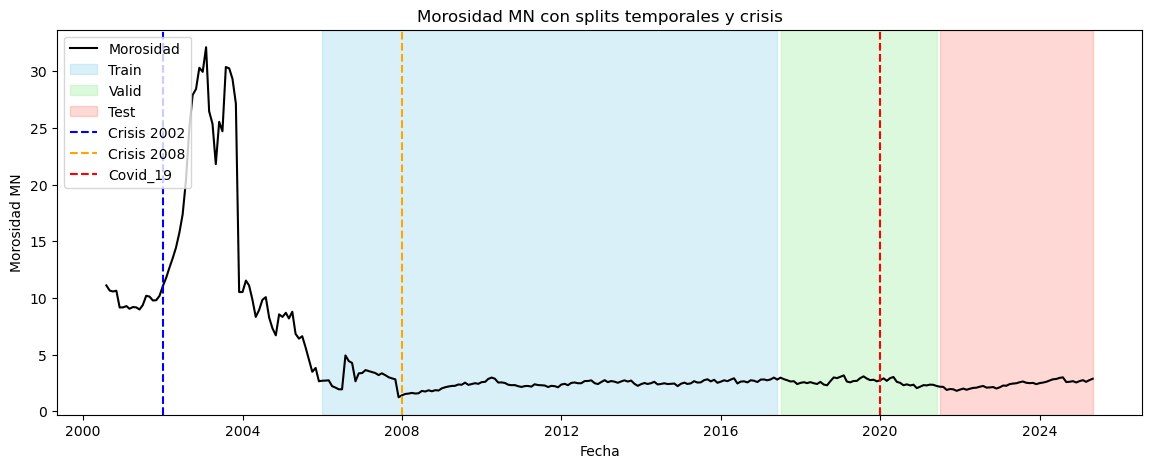

In [28]:
import matplotlib.pyplot as plt

# Supongamos que df tiene columnas 'Fecha' y 'Morosidad_MN'
plt.figure(figsize=(14,5))

# Línea de la serie
splits = pd.DataFrame({
    'Conjunto': ['Train', 'Valid', 'Test'],
    'Fecha Inicio': ['2006-01', '2017-07', '2021-07'],
    'Fecha Fin': ['2017-06', '2021-06', '2025-05'],
    'Meses': [125, 42, 42]
})
# Convertir a datetime
splits['Fecha Inicio'] = pd.to_datetime(splits['Fecha Inicio'])
splits['Fecha Fin'] = pd.to_datetime(splits['Fecha Fin'])

plt.figure(figsize=(14,5))

# Línea de la serie
# df = df[df['Fecha'] >= '2008-01-01']
plt.plot(df['Fecha'], df['Morosidad_MN'], color='black', label='Morosidad')

# Colorear los splits
colors = ['skyblue', 'lightgreen', 'salmon']
for i, row in splits.iterrows():
    plt.axvspan(row['Fecha Inicio'], row['Fecha Fin'], color=colors[i], alpha=0.3, label=row['Conjunto'])

# Diccionario con fechas
crisis_dates = {
    'Crisis 2002': '2002-01-01',
    'Crisis 2008': '2008-01-01',
    'Covid_19': '2020-01-01'
}

# Marcar crisis
crisis_colors = {
    'Crisis 2002': 'blue',
    'Crisis 2008': 'orange',
    'Covid_19': 'red'
}

# Dibujar líneas de crisis
for label, date in crisis_dates.items():
    plt.axvline(pd.to_datetime(date), color=crisis_colors[label], linestyle='--', label=label)

# Leyenda sin duplicados
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

# Etiquetas y título
plt.title('Morosidad MN con splits temporales y crisis')
plt.xlabel('Fecha')
plt.ylabel('Morosidad MN')
plt.savefig('Split_temporal.jpg', dpi=300, bbox_inches='tight')
plt.show()


# Correlaciones

           TMN_lag3  DS_m_lag5  IF_a_lag3
TMN_lag3   1.000000  -0.030709   0.443274
DS_m_lag5 -0.030709   1.000000   0.041804
IF_a_lag3  0.443274   0.041804   1.000000


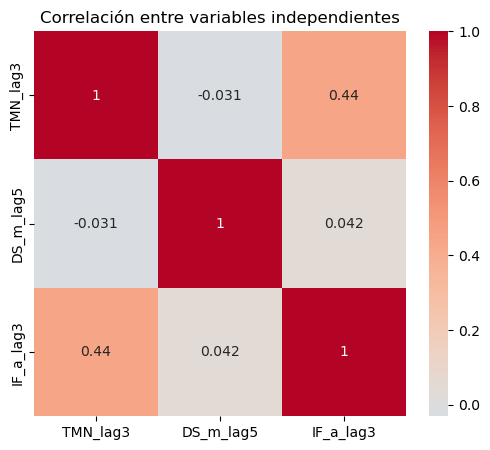

In [30]:
vars_sel = ['TMN_lag3', 'DS_m_lag5', 'IF_a_lag3']
print(df[vars_sel].corr())

corr_matrix = df[vars_sel].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre variables independientes')
plt.show()

# LR

In [32]:
#Incorporaciòn del factor autoregresivo
df['Morosidad_lag1'] = df['Morosidad_MN'].shift(1)

vars_final_RL = [
  #  'Morosidad_lag1',   # componente AR
    'TMN_lag3',
    'DS_m_lag5',
    'IF_a_lag3'
]

IND_REGRESION = (
    df[['Fecha', 'Morosidad_MN'] + vars_final_RL]
    .dropna()
    .copy()
)

In [33]:
X_train, y_train, X_valid, y_valid, X_test, y_test = \
    temporal_split(IND_REGRESION, target='Morosidad_MN')

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_valid = lr.predict(X_valid)
pred_test  = lr.predict(X_test)

In [35]:
rmse_valid_lr = mean_squared_error(y_valid, pred_valid, squared=False)
rmse_test_lr  = mean_squared_error(y_test, pred_test, squared=False)
r2_valid_lr   = r2_score(y_valid, pred_valid)
r2_test_lr    = r2_score(y_test, pred_test)

print('\n=== LINEAR REGRESSION ===')
print('RMSE Valid:', rmse_valid_lr)
print('RMSE Test :', rmse_test_lr)
print('MAE Valid :', mean_absolute_error(y_valid, pred_valid))
print('MAE Test  :', mean_absolute_error(y_test, pred_test))
print('MAPE Valid:', mape(y_valid, pred_valid))
print('MAPE Test :', mape(y_test, pred_test))
print('R2 Valid  :', r2_valid_lr)
print('R2 Test   :', r2_test_lr)



=== LINEAR REGRESSION ===
RMSE Valid: 0.3397847155384203
RMSE Test : 0.3005060289433845
MAE Valid : 0.2547789946274045
MAE Test  : 0.2509547091298511
MAPE Valid: 9.204438569586046
MAPE Test : 10.492610085848893
R2 Valid  : -0.6529548324015813
R2 Test   : 0.11264976699252327


C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [36]:
coef = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': lr.coef_
})

# Agregar intercepto
intercepto = pd.DataFrame({
    'Variable': ['Intercepto'],
    'Coeficiente': [lr.intercept_]
})

coef = (
    pd.concat([intercepto, coef], ignore_index=True)
      .sort_values(by='Coeficiente', key=abs, ascending=False)
)

print(coef)

     Variable  Coeficiente
0  Intercepto     1.486318
1    TMN_lag3     0.053992
2   DS_m_lag5     0.040698
3   IF_a_lag3    -0.015068


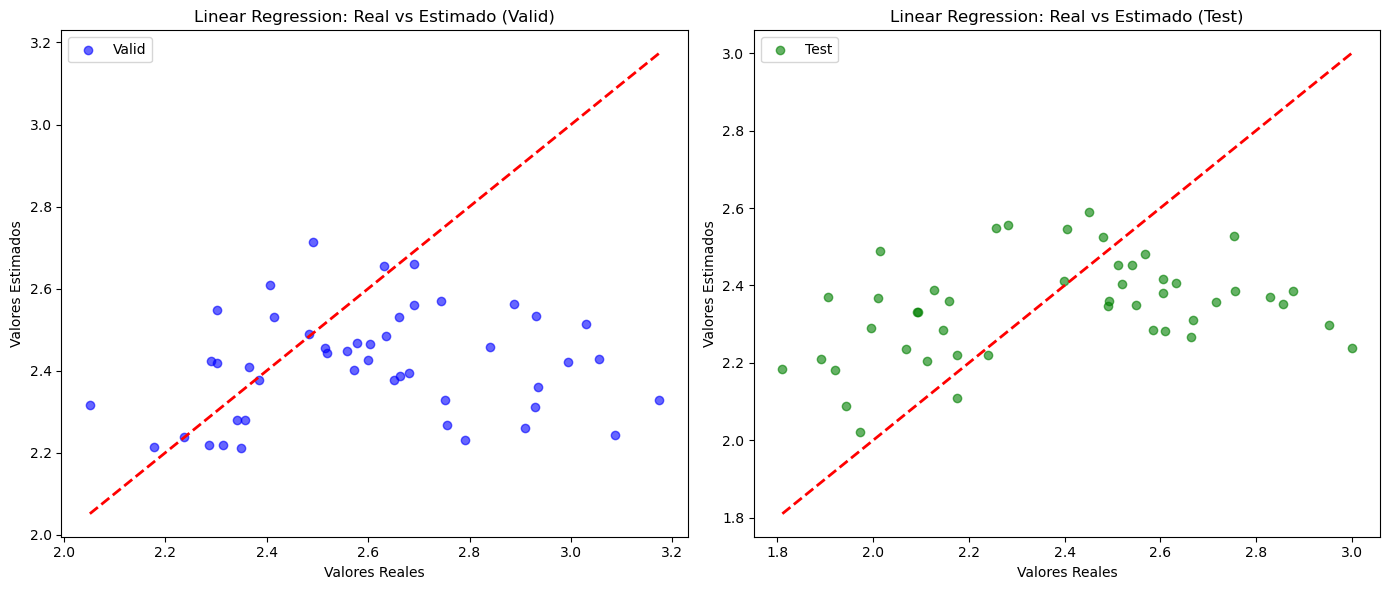

In [37]:
# Crea figura y subplots
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# --- Plot Valid ---
axes[0].scatter(y_valid, pred_valid, alpha=0.6, color='blue', label='Valid')
axes[0].plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=2)
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Valores Estimados')
axes[0].set_title('Linear Regression: Real vs Estimado (Valid)')
axes[0].legend()

# --- Plot Test ---
axes[1].scatter(y_test, pred_test, alpha=0.6, color='green', label='Test')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valores Reales')
axes[1].set_ylabel('Valores Estimados')
axes[1].set_title('Linear Regression: Real vs Estimado (Test)')
axes[1].legend()

plt.tight_layout()

# Guardar la figura
plt.savefig('real_vs_estimado_LR.png', dpi=300)
plt.show()

# Random Forest

In [39]:
vars_final_RF = [
    'Morosidad_lag1',
    'TMN_lag1','TMN_lag3','TMN_lag6',
    'DS_m_lag1','DS_m_lag3','DS_m_lag6',
    'IF_a_lag1','IF_a_lag2','IF_a_lag4'
]

IND_RF = (
    df[['Fecha', 'Morosidad_MN'] + vars_final_RF]
    .dropna()
    .copy()
)

In [40]:
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.ensemble import RandomForestRegressor

X_train_rf, y_train_rf, X_valid_rf, y_valid_rf, X_test_rf, y_test_rf = temporal_split(IND_RF)

param_space_rf = {
    'n_estimators': Integer(100, 600),
    'max_depth': Integer(3, 8),
    'min_samples_split': Integer(5, 20),
    'min_samples_leaf': Integer(5, 20),
    'max_features': Real(0.4, 0.8)
}

tscv = TimeSeriesSplit(n_splits=4)

opt_rf = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=0),
    search_spaces=param_space_rf,
    n_iter=30,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    random_state=0
)

opt_rf.fit(X_train_rf, y_train_rf)

pred_valid_rf = opt_rf.predict(X_valid_rf)
pred_test_rf  = opt_rf.predict(X_test_rf)

rmse_valid_rf = mean_squared_error(y_valid_rf, pred_valid_rf, squared=False)
rmse_test_rf  = mean_squared_error(y_test_rf, pred_test_rf, squared=False)

print('\n===== RANDOM FOREST =====')
print('RMSE Valid:', rmse_valid_rf)
print('RMSE Test :', rmse_test_rf)
print('MAE Valid :', mean_absolute_error(y_valid_rf, pred_valid_rf))
print('MAE Test  :', mean_absolute_error(y_test_rf, pred_test_rf))
print('MAPE Valid:', mape(y_valid_rf, pred_valid_rf))
print('MAPE Test :', mape(y_test_rf, pred_test_rf))
print('R2 Valid  :', r2_score(y_valid_rf, pred_valid_rf))
print('R2 Test   :', r2_score(y_test_rf, pred_test_rf))


===== RANDOM FOREST =====
RMSE Valid: 0.20717049853887207
RMSE Test : 0.12521995076680073
MAE Valid : 0.15989740504981012
MAE Test  : 0.0835803289711936
MAPE Valid: 6.001494435874576
MAPE Test : 3.5289712718990374
R2 Valid  : 0.3715099105515701
R2 Test   : 0.8380087926574228


C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# XGB

In [42]:
vars_final_XGB = [
    'Morosidad_lag1',
    'TMN_lag1','TMN_lag3','TMN_lag6',
    'DS_m_lag1','DS_m_lag3','DS_m_lag6',
    'IF_a_lag1','IF_a_lag2','IF_a_lag4'
]

IND_XGB = (
    df[['Fecha', 'Morosidad_MN'] + vars_final_XGB]
    .dropna()
    .copy()
)

In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from xgboost import XGBRegressor

# --- Datos ---
X_train_xgb, y_train_xgb, X_valid_xgb, y_valid_xgb, X_test_xgb, y_test_xgb = temporal_split(IND_XGB)

# Conversión a NumPy
Xtr = np.asarray(X_train_xgb, dtype=np.float64)
ytr = np.asarray(y_train_xgb, dtype=np.float64)
Xva = np.asarray(X_valid_xgb, dtype=np.float64)
yva = np.asarray(y_valid_xgb, dtype=np.float64)
Xte = np.asarray(X_test_xgb, dtype=np.float64)
yte = np.asarray(y_test_xgb, dtype=np.float64)

# --- Espacio de búsqueda para BayesSearchCV ---
param_space = {
    'n_estimators': Integer(100, 600),
    'max_depth': Integer(3, 8),
    'learning_rate': Real(0.01, 0.1, 'log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'gamma': Real(0, 5)
}

# --- Validador temporal ---
tscv = TimeSeriesSplit(n_splits=4)

# --- BayesSearchCV ---
opt_xgb = BayesSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=0),
    search_spaces=param_space,
    n_iter=30,                 # número de combinaciones a probar
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=0
)

# --- Ajuste Bayesiano ---
opt_xgb.fit(Xtr, ytr)

# --- Predicciones ---
pred_valid_xgb = opt_xgb.predict(Xva)
pred_test_xgb  = opt_xgb.predict(Xte)

# --- Métricas ---
rmse_valid_xgb = mean_squared_error(yva, pred_valid_xgb, squared=False)
rmse_test_xgb  = mean_squared_error(yte, pred_test_xgb, squared=False)

print('\n===== XGBOOST (Bayesian Optimization) =====')
print('RMSE Valid:', rmse_valid_xgb)
print('RMSE Test :', rmse_test_xgb)
print('MAE Valid :', mean_absolute_error(yva, pred_valid_xgb))
print('MAE Test  :', mean_absolute_error(yte, pred_test_xgb))
print('MAPE Valid:', mape(yva, pred_valid_xgb))
print('MAPE Test :', mape(yte, pred_test_xgb))
print('R2 Valid  :', r2_score(yva, pred_valid_xgb))
print('R2 Test   :', r2_score(yte, pred_test_xgb))

# --- Mejor conjunto de hiperparámetros encontrados ---
print('\nMejores hiperparámetros XGB:', opt_xgb.best_params_)


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Comparativa de modelos

In [45]:
# y las métricas RMSE calculadas previamente

# Crear diccionario con métricas
metrics_dict = {
    'Modelo': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE Valid': [rmse_valid_lr, rmse_valid_rf, rmse_valid_xgb],
    'RMSE Test' : [rmse_test_lr, rmse_test_rf, rmse_test_xgb],
    'MAE Valid' : [
        mean_absolute_error(y_valid, pred_valid),
        mean_absolute_error(y_valid_rf, pred_valid_rf),
        mean_absolute_error(yva, pred_valid_xgb)
    ],
    'MAE Test'  : [
        mean_absolute_error(y_test, pred_test),
        mean_absolute_error(y_test_rf, pred_test_rf),
        mean_absolute_error(yte, pred_test_xgb)
    ],
    'MAPE Valid (%)' : [
        mape(y_valid, pred_valid),
        mape(y_valid_rf, pred_valid_rf),
        mape(yva, pred_valid_xgb)
    ],
    'MAPE Test (%)'  : [
        mape(y_test, pred_test),
        mape(y_test_rf, pred_test_rf),
        mape(yte, pred_test_xgb)
    ],
    'R2 Valid' : [
        r2_valid_lr,
        r2_score(y_valid_rf, pred_valid_rf),
        r2_score(yva, pred_valid_xgb)
    ],
    'R2 Test'  : [
        r2_test_lr,
        r2_score(y_test_rf, pred_test_rf),
        r2_score(yte, pred_test_xgb)
    ]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Mostrar tabla
print(metrics_df)

# Opcional: guardar a CSV
metrics_df.to_csv('comparativa_modelos.csv', index=False)

              Modelo  RMSE Valid  RMSE Test  MAE Valid  MAE Test  \
0  Linear Regression    0.339785   0.300506   0.254779  0.250955   
1      Random Forest    0.207170   0.125220   0.159897  0.083580   
2            XGBoost    0.191982   0.175387   0.146453  0.137656   

   MAPE Valid (%)  MAPE Test (%)  R2 Valid   R2 Test  
0        9.204439      10.492610 -0.652955  0.112650  
1        6.001494       3.528971  0.371510  0.838009  
2        5.540268       6.262393  0.460286  0.682212  


## Analisis de correlacion de los datos

In [47]:
cols_needed = ['Morosidad_MN'] + list(set(
    vars_final_RL + vars_final_RF + vars_final_XGB
))

df_corr = df[cols_needed].dropna().copy()


In [48]:
import pandas as pd

results = []

for var in cols_needed:
    if var != 'Morosidad_MN':
        results.append({
            'Variable': var,
            'Pearson': df_corr['Morosidad_MN'].corr(df_corr[var], method='pearson'),
            'Spearman': df_corr['Morosidad_MN'].corr(df_corr[var], method='spearman')
        })

corr_target = pd.DataFrame(results).sort_values(
    by='Pearson', key=abs, ascending=False
)

corr_target


,Variable,Pearson,Spearman
9,Morosidad_lag1,0.977937,0.925014
6,TMN_lag3,0.946967,0.624625
3,TMN_lag6,0.937733,0.672508
11,TMN_lag1,0.910652,0.578666
5,IF_a_lag2,0.362276,-0.085892
7,IF_a_lag3,0.347013,-0.112472
8,IF_a_lag1,0.345590,-0.084946
1,IF_a_lag4,0.325193,-0.110253
10,DS_m_lag6,-0.047239,-0.093457
0,DS_m_lag1,0.038168,-0.078601


In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_corr[vars_final_RL]

vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

vif



,Variable,VIF
0,TMN_lag3,2.720347
1,DS_m_lag5,1.005291
2,IF_a_lag3,2.725350


In [50]:
corr_RF = df_corr[vars_final_RF].corr(method='pearson')
corr_RF


,Morosidad_lag1,TMN_lag1,TMN_lag3,TMN_lag6,DS_m_lag1,DS_m_lag3,DS_m_lag6,IF_a_lag1,IF_a_lag2,IF_a_lag4
Morosidad_lag1,1.000000,0.934691,0.952720,0.922455,0.025234,0.001835,-0.051484,0.366374,0.351764,0.289484
TMN_lag1,0.934691,1.000000,0.966088,0.854397,0.028982,-0.027872,-0.068042,0.447613,0.423972,0.333609
TMN_lag3,0.952720,0.966088,1.000000,0.934975,0.043856,0.028291,-0.055546,0.412605,0.432416,0.418146
TMN_lag6,0.922455,0.854397,0.934975,1.000000,0.038425,0.038387,0.024477,0.268587,0.308991,0.403609
DS_m_lag1,0.025234,0.028982,0.043856,0.038425,1.000000,0.014495,-0.086316,0.193993,0.101182,0.030249
DS_m_lag3,0.001835,-0.027872,0.028291,0.038387,0.014495,1.000000,-0.087080,0.043356,0.145695,0.103928
DS_m_lag6,-0.051484,-0.068042,-0.055546,0.024477,-0.086316,-0.087080,1.000000,-0.085242,-0.099044,0.042379
IF_a_lag1,0.366374,0.447613,0.412605,0.268587,0.193993,0.043356,-0.085242,1.000000,0.751124,0.280730
IF_a_lag2,0.351764,0.423972,0.432416,0.308991,0.101182,0.145695,-0.099044,0.751124,1.000000,0.506372
IF_a_lag4,0.289484,0.333609,0.418146,0.403609,0.030249,0.103928,0.042379,0.280730,0.506372,1.000000


In [51]:
def base_var(name):
    return name.split('_lag')[0]

df_long = corr_target.copy()
df_long['Base'] = df_long['Variable'].apply(base_var)

corr_grouped = (
    df_long
    .groupby('Base')[['Pearson','Spearman']]
    .apply(lambda x: x.abs().mean())
    .reset_index()
    .sort_values('Pearson', ascending=False)
)

corr_grouped


,Base,Pearson,Spearman
2,Morosidad,0.977937,0.925014
3,TMN,0.931784,0.625266
1,IF_a,0.345018,0.098391
0,DS_m,0.032814,0.090399


In [54]:


# asegurar formato fecha
df['Fecha'] = pd.to_datetime(df['Fecha'])

vars_all = ['Morosidad_MN', 'TMN', 'DS_m', 'IF_a']
window = 6




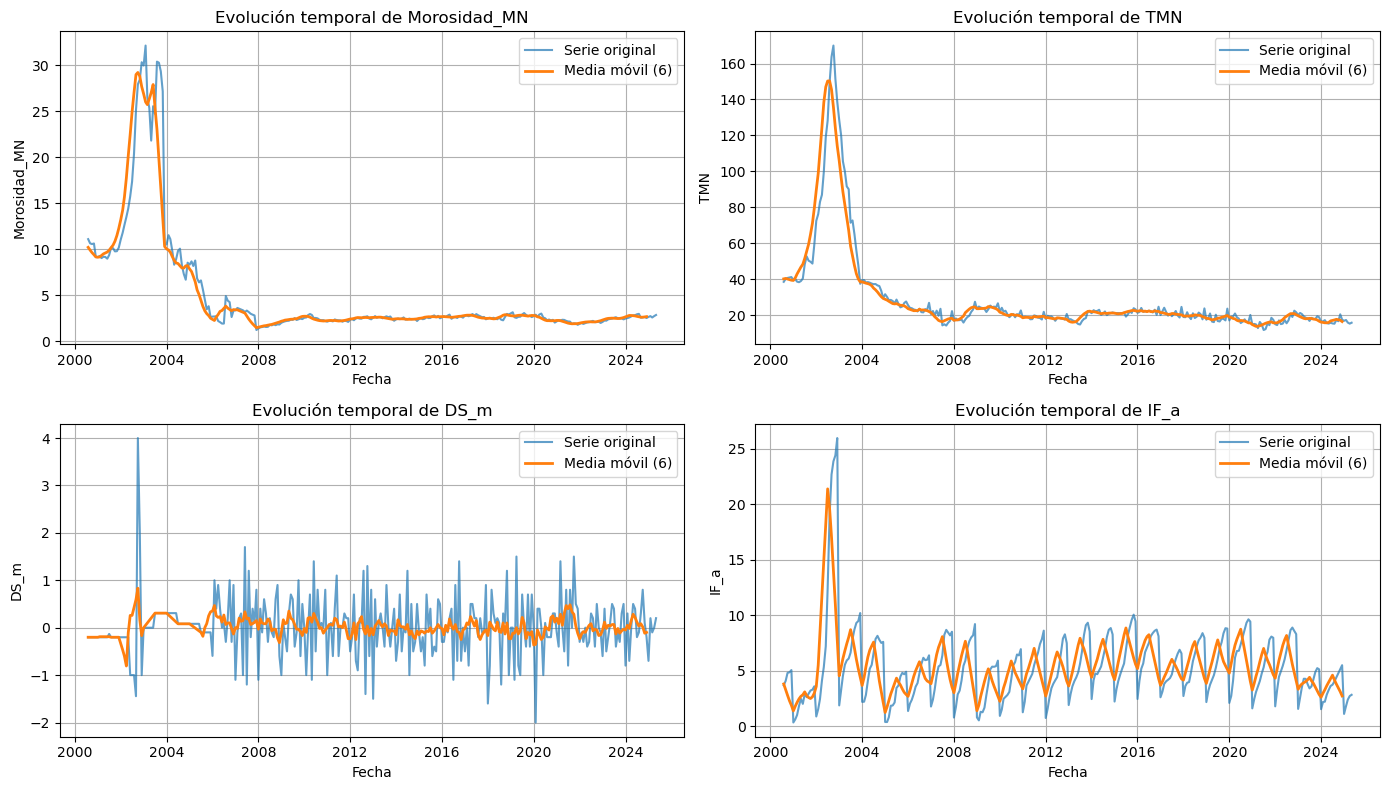

In [55]:
import matplotlib.pyplot as plt

# Asegura que Fecha es datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Variables a graficar
vars_all = ['Morosidad_MN', 'TMN', 'DS_m', 'IF_a']

# Ventana de media móvil
window = 6  

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, var in enumerate(vars_all):
    ax = axes[i]
    
    # Serie original
    ax.plot(df['Fecha'], df[var], label='Serie original', alpha=0.7)
    
    # Media móvil
    ax.plot(
        df['Fecha'],
        df[var].rolling(window=window).mean(),
        label=f'Media móvil ({window})',
        linewidth=2
    )
    
    ax.set_title(f'Evolución temporal de {var}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel(var)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig('Evol temporal variables_inicial.png', dpi=300)
plt.show()


# Feature Importance

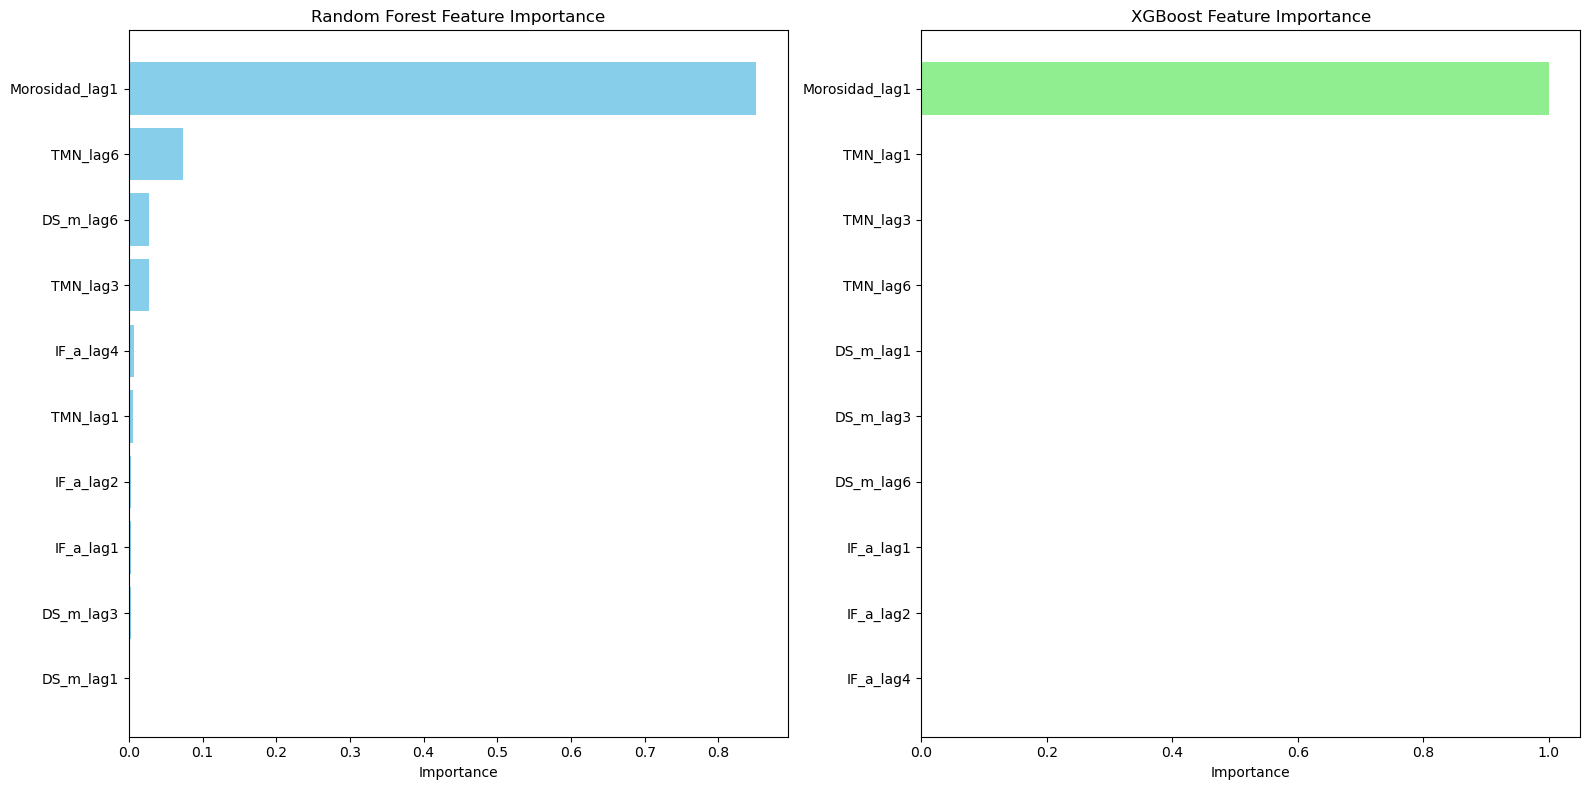

In [57]:
import matplotlib.pyplot as plt

# --- Feature Importance para Random Forest ---
fi_rf = opt_rf.best_estimator_.feature_importances_
features_rf = X_train_rf.columns
df_fi_rf = pd.DataFrame({'Feature': features_rf, 'Importance': fi_rf})
df_fi_rf = df_fi_rf.sort_values(by='Importance', ascending=False)

# --- Feature Importance para XGBoost ---
fi_xgb = opt_xgb.best_estimator_.feature_importances_
features_xgb = X_train_xgb.columns
df_fi_xgb = pd.DataFrame({'Feature': features_xgb, 'Importance': fi_xgb})
df_fi_xgb = df_fi_xgb.sort_values(by='Importance', ascending=False)

# --- Crear figura 2x1 ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Random Forest ---
axes[0].barh(df_fi_rf['Feature'], df_fi_rf['Importance'], color='skyblue')
axes[0].invert_yaxis()
axes[0].set_title("Random Forest Feature Importance")
axes[0].set_xlabel("Importance")

# --- XGBoost ---
axes[1].barh(df_fi_xgb['Feature'], df_fi_xgb['Importance'], color='lightgreen')
axes[1].invert_yaxis()
axes[1].set_title("XGBoost Feature Importance")
axes[1].set_xlabel("Importance")

# --- Ajuste y guardar imagen ---
plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300)
plt.show()


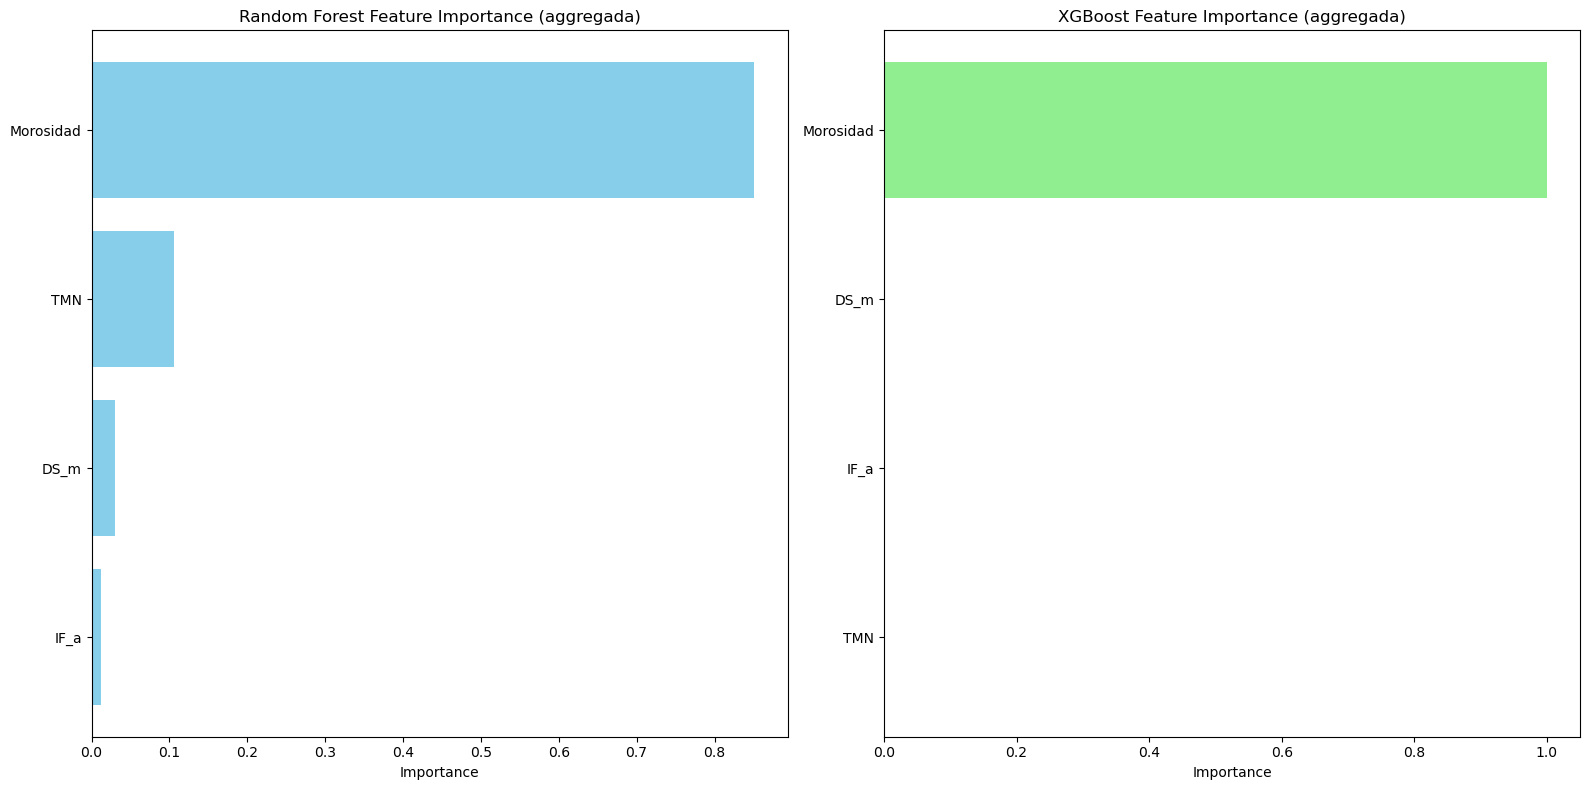

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# --- RANDOM FOREST ---
fi_rf = opt_rf.best_estimator_.feature_importances_
features_rf = X_train_rf.columns
df_fi_rf = pd.DataFrame({'Feature': features_rf, 'Importance': fi_rf})

# Agrupar por variable base (eliminar _lagX)
df_fi_rf['BaseVar'] = df_fi_rf['Feature'].str.replace(r'_lag\d+', '', regex=True)
df_fi_rf_agg = df_fi_rf.groupby('BaseVar')['Importance'].sum().sort_values(ascending=False)

# --- XGBOOST ---
fi_xgb = opt_xgb.best_estimator_.feature_importances_
features_xgb = X_train_xgb.columns
df_fi_xgb = pd.DataFrame({'Feature': features_xgb, 'Importance': fi_xgb})
df_fi_xgb['BaseVar'] = df_fi_xgb['Feature'].str.replace(r'_lag\d+', '', regex=True)
df_fi_xgb_agg = df_fi_xgb.groupby('BaseVar')['Importance'].sum().sort_values(ascending=False)

# --- FIGURA COMPARATIVA 2x1 ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest
axes[0].barh(df_fi_rf_agg.index, df_fi_rf_agg.values, color='skyblue')
axes[0].invert_yaxis()
axes[0].set_title("Random Forest Feature Importance (aggregada)")
axes[0].set_xlabel("Importance")

# XGBoost
axes[1].barh(df_fi_xgb_agg.index, df_fi_xgb_agg.values, color='lightgreen')
axes[1].invert_yaxis()
axes[1].set_title("XGBoost Feature Importance (aggregada)")
axes[1].set_xlabel("Importance")

plt.tight_layout()
plt.savefig('feature_importance_basevars.png', dpi=300)
plt.show()


# PDP

C:\Users\carol\anaconda3\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


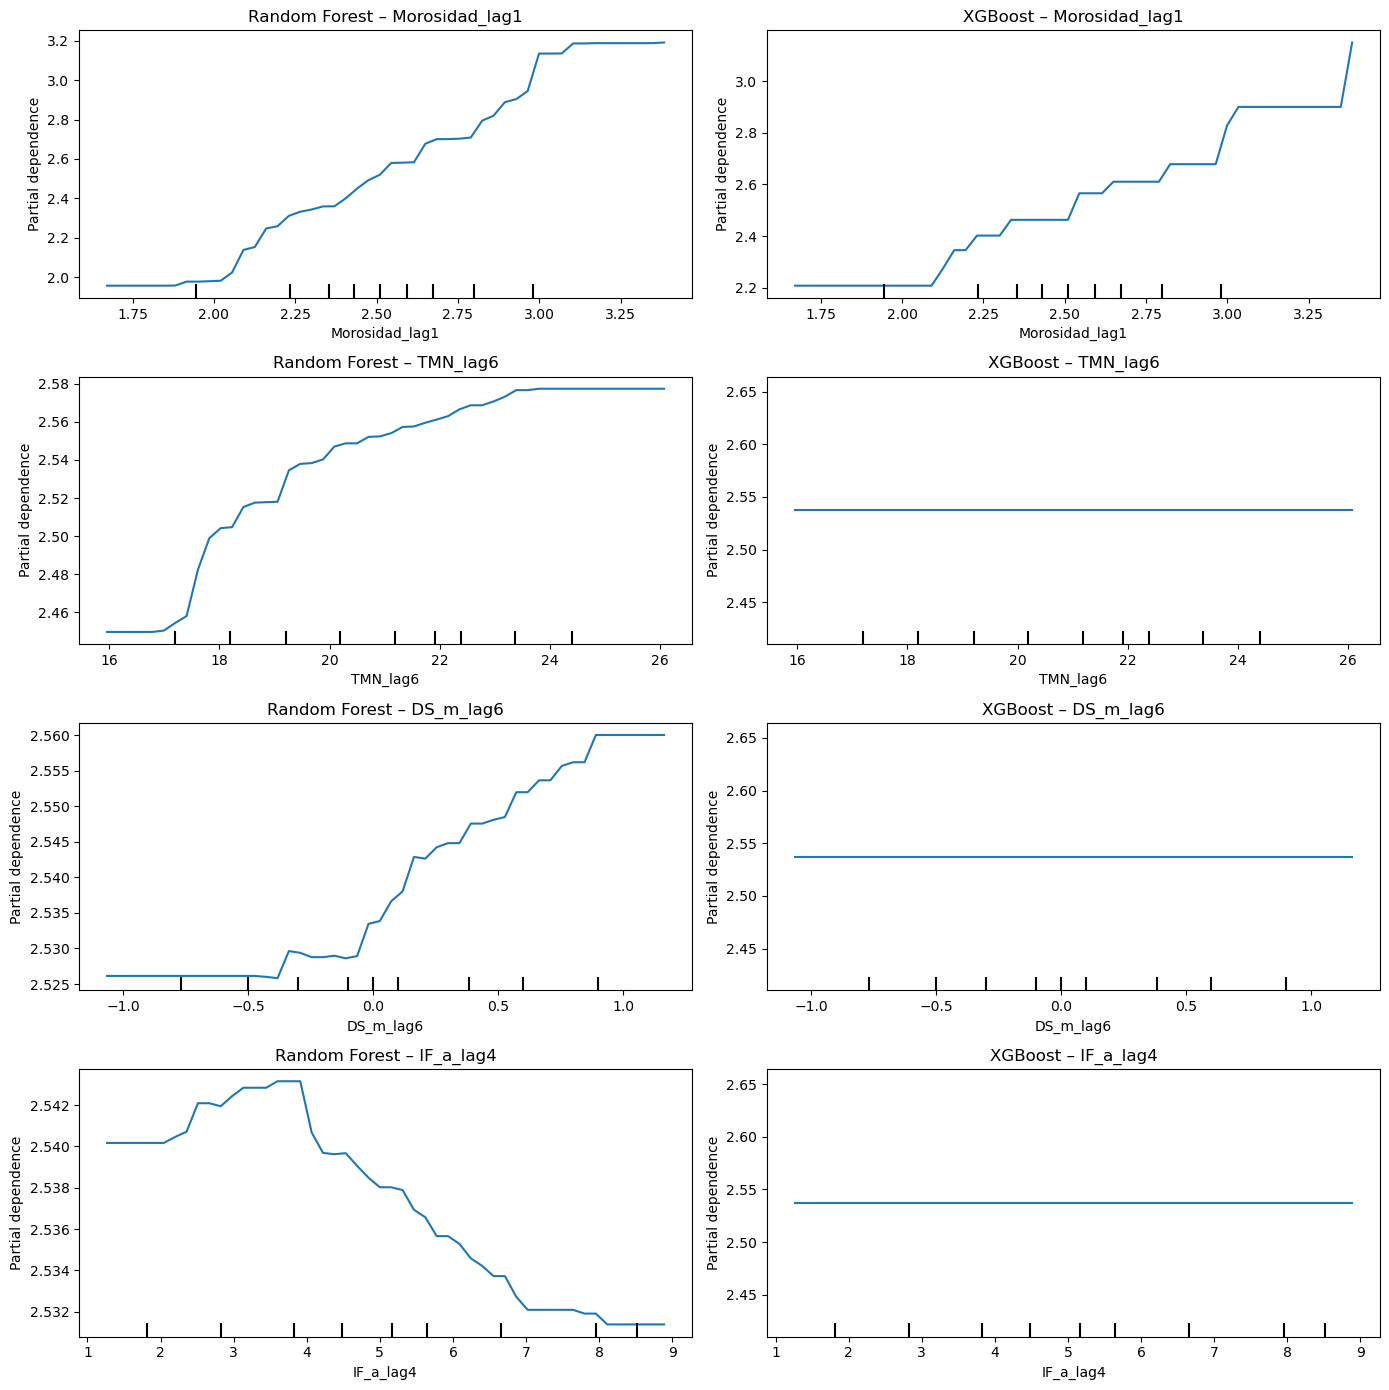

In [60]:
 import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Variables a analizar (RF y XGB)
features_pdp = ['Morosidad_lag1', 'TMN_lag6', 'DS_m_lag6', 'IF_a_lag4']

# Crear figura: filas = variables, columnas = modelos
fig, axes = plt.subplots(len(features_pdp), 2, figsize=(14, 14))

for i, feat in enumerate(features_pdp):

    # --- Random Forest ---
    PartialDependenceDisplay.from_estimator(
        opt_rf.best_estimator_,
        X_train_rf,
        features=[feat],
        ax=axes[i, 0],
        grid_resolution=50
    )
    axes[i, 0].set_title(f"Random Forest – {feat}")

    # --- XGBoost ---
    PartialDependenceDisplay.from_estimator(
        opt_xgb.best_estimator_,
        X_train_xgb,
        features=[feat],
        ax=axes[i, 1],
        grid_resolution=50
    )
    axes[i, 1].set_title(f"XGBoost – {feat}")

plt.tight_layout()
plt.savefig("pdp_rf_xgb.png", dpi=300, bbox_inches="tight")
plt.show()



Variables en la regresión lineal:
['TMN_lag3' 'DS_m_lag5' 'IF_a_lag3']


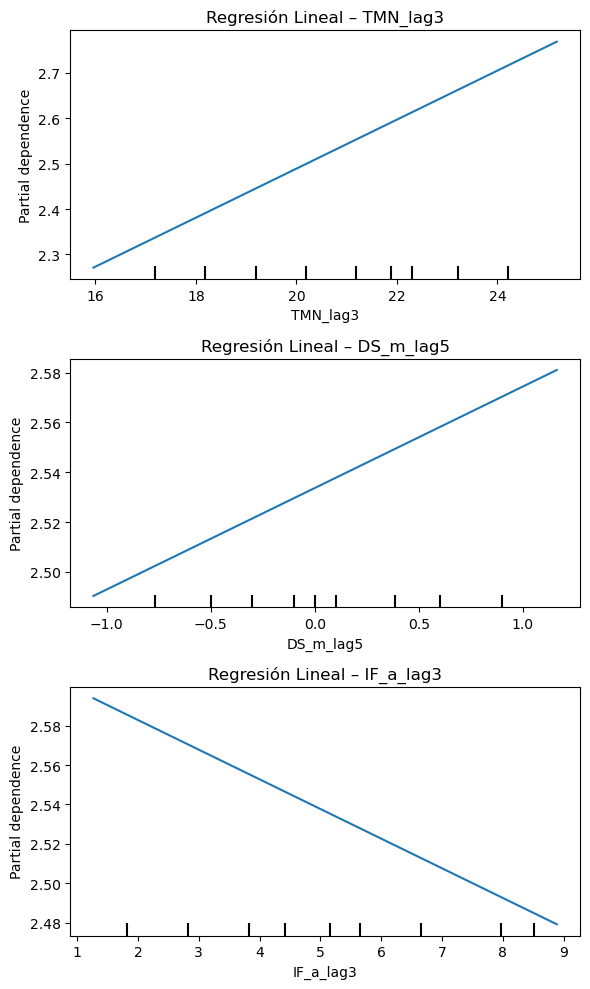

In [61]:
print("Variables en la regresión lineal:")
print(lr.feature_names_in_)
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Variables reales del modelo LR
features_lr = list(lr.feature_names_in_)

fig, axes = plt.subplots(len(features_lr), 1, figsize=(6, 10))

for i, feat in enumerate(features_lr):
    PartialDependenceDisplay.from_estimator(
        lr,
        X_train[features_lr],
        features=[feat],
        ax=axes[i],
        grid_resolution=50
    )
    axes[i].set_title(f"Regresión Lineal – {feat}")

plt.tight_layout()
plt.savefig("pdp_lr.png", dpi=300, bbox_inches="tight")
plt.show()


# SHAP (RF)

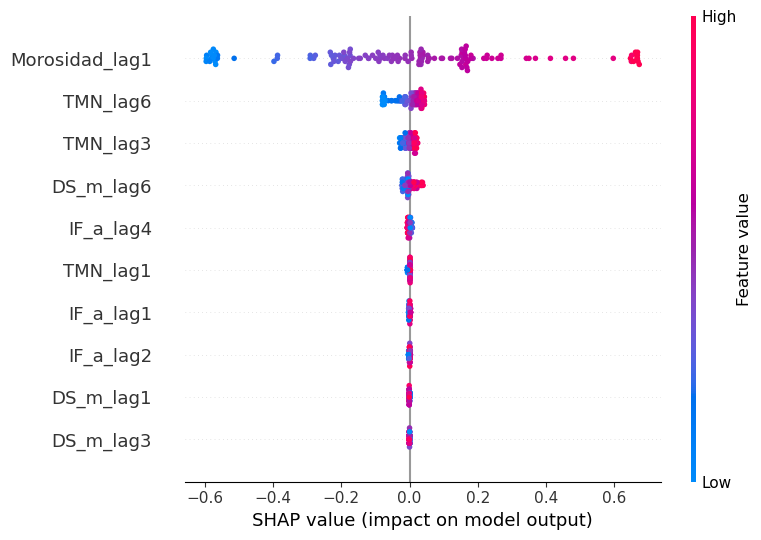

In [63]:
import shap
import matplotlib.pyplot as plt

best_rf = opt_rf.best_estimator_

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train_rf)

# Crear el plot SIN mostrarlo
shap.summary_plot(
    shap_values,
    X_train_rf,
    show=False
)

# Guardar figura
plt.savefig("shap_summary_rf.png", dpi=300, bbox_inches="tight")
plt.close()
shap.summary_plot(shap_values, X_train_rf)

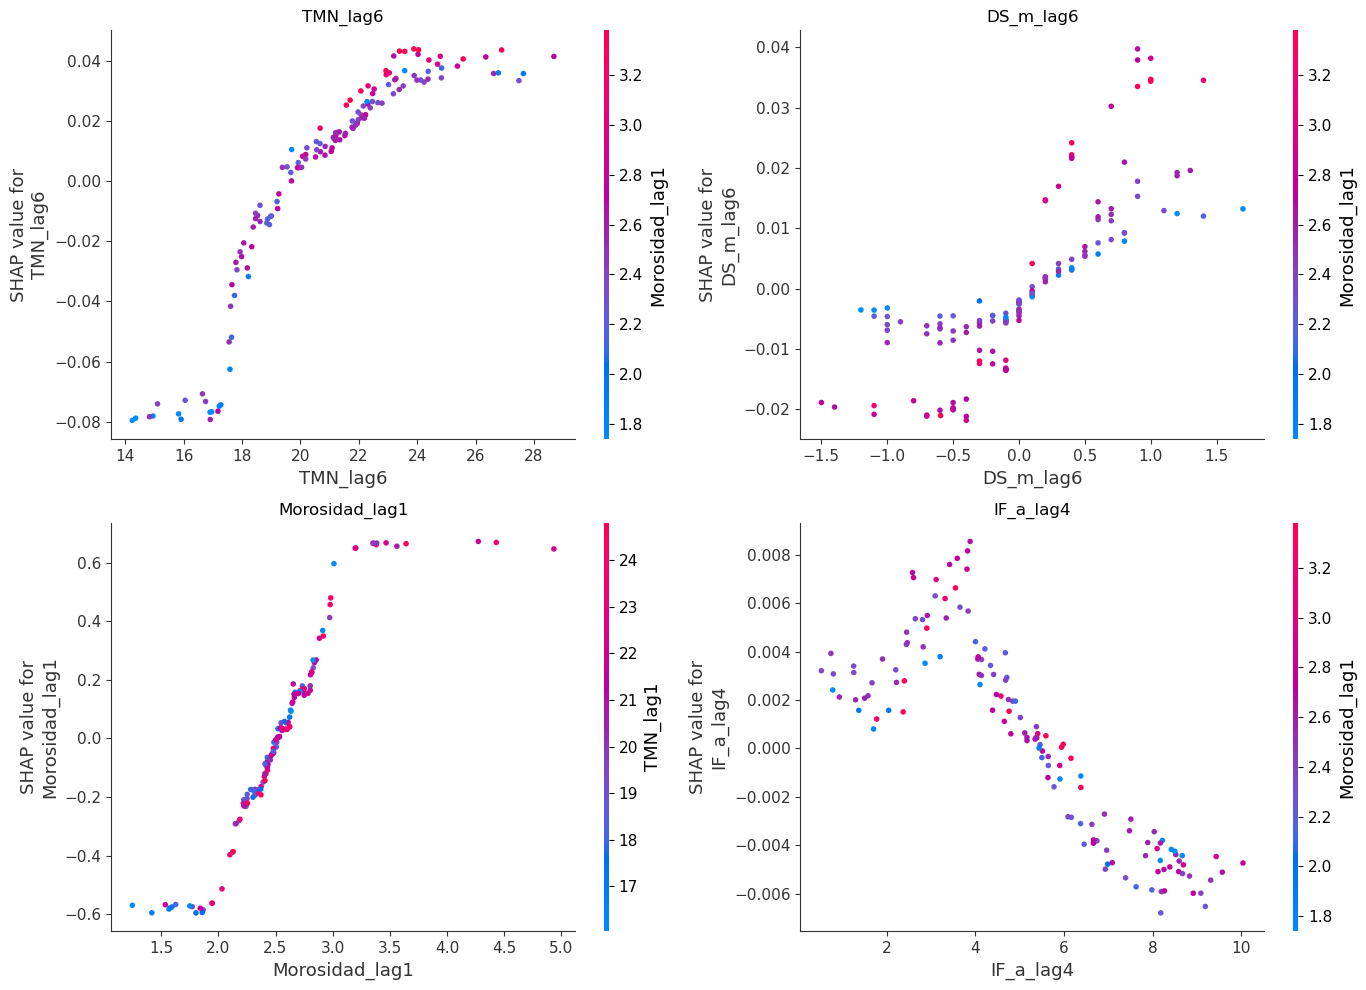

In [64]:
# Crea figura
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  

# Lista de variables y sus títulos
variables = ['TMN_lag6', 'DS_m_lag6', 'Morosidad_lag1', 'IF_a_lag4']
axes_flat = axes.flatten()  # para indexar 

# Dibujar cada dependence plot en su subplot
for i, var in enumerate(variables):
    shap.dependence_plot(var, shap_values, X_train_rf, ax=axes_flat[i], show=False)
    axes_flat[i].set_title(var, fontsize=12)

plt.tight_layout()

# Guardar la figura
plt.savefig('shap_dependence_plots_2x2.png', dpi=300)
plt.show()

# SHAP XGB

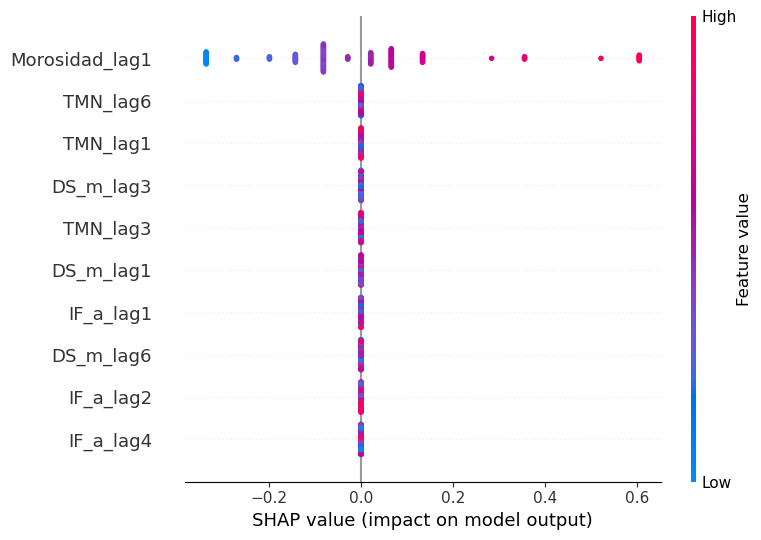

In [79]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(opt_xgb.predict, Xtr)
shap_values = explainer(Xtr)

shap.summary_plot(
    shap_values.values,
    X_train_xgb,
    show=True
)

# Guardar la figura
plt.savefig("shap_summary_xgb.png", dpi=300, bbox_inches="tight")
plt.close()
# shap.summary_plot(shap_values.values, X_train_xgb)

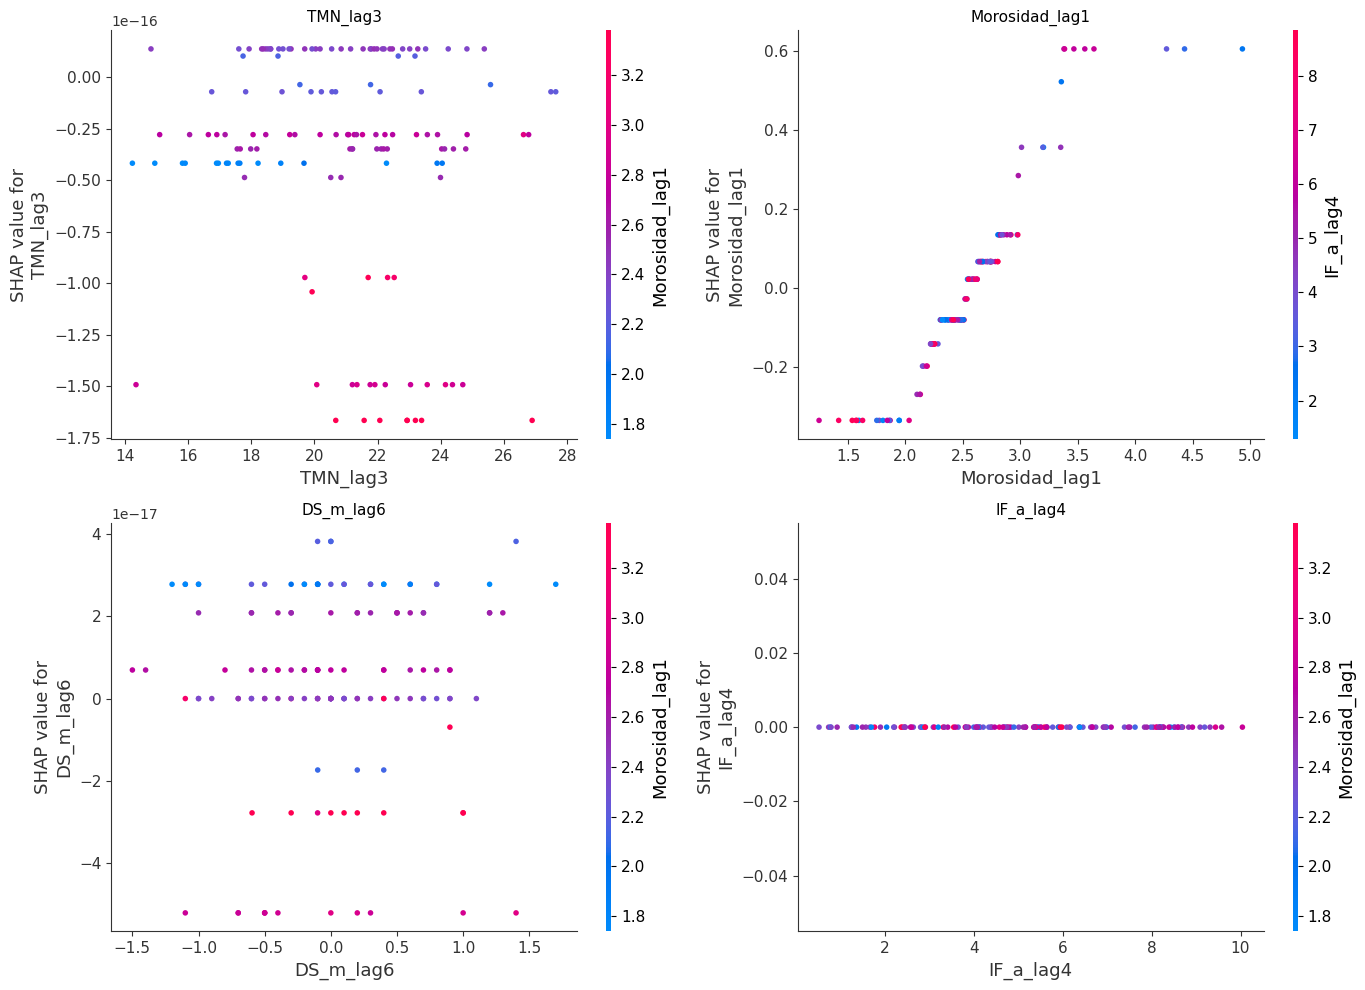

In [67]:
import shap
import matplotlib.pyplot as plt

# --- Datos ---
X = X_train_xgb
shap_vals = shap_values.values   # 🔑 NUMPY PURO

features = ['TMN_lag3', 'Morosidad_lag1', 'DS_m_lag6', 'IF_a_lag4']

# --- Figura 2x2 ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    shap.dependence_plot(
        feat,
        shap_vals,   # numpy array
        X,
        ax=ax,
        show=False
    )
    ax.set_title(feat, fontsize=11)

plt.tight_layout()
plt.savefig("shap_dependence_xgb_2x2.png", dpi=300)
plt.show()



# Comparación objetiva RF vs XGBoost

ExactExplainer explainer: 140it [05:17,  2.34s/it]                                                                     


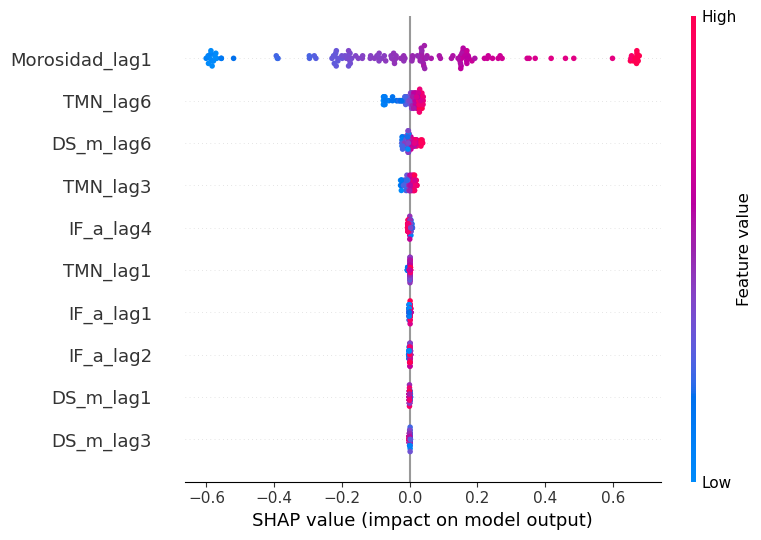

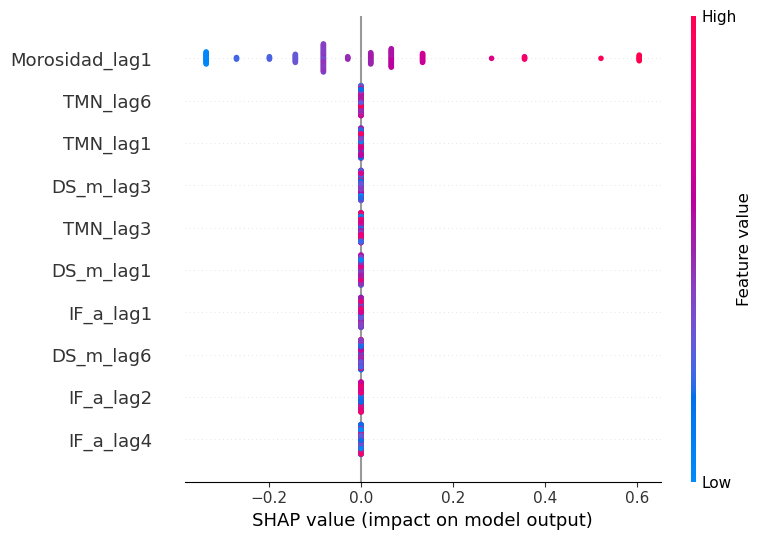

                 RF_SHAP      XGB_SHAP
Feature                               
Morosidad_lag1  0.250700  1.596085e-01
TMN_lag6        0.026354  8.968146e-17
TMN_lag1        0.001702  8.339153e-17
DS_m_lag3       0.000710  4.749898e-17
TMN_lag3        0.010367  4.545225e-17
DS_m_lag1       0.000784  3.636679e-17
IF_a_lag1       0.001279  1.929412e-17
DS_m_lag6       0.010794  1.724739e-17
IF_a_lag2       0.001089  1.075778e-17
IF_a_lag4       0.003317  0.000000e+00


In [95]:
import shap

explainer_rf = shap.Explainer(
    best_rf.predict,   # 🔑 función de predicción
    X_train_rf
)

shap_values_rf = explainer_rf(X_train_rf)
shap.summary_plot(
    shap_values_rf.values,
    X_train_rf,
    show=True
)
explainer_xgb = shap.Explainer(
    opt_xgb.predict,
    X_train_xgb
)

shap_values_xgb = explainer_xgb(X_train_xgb)

shap.summary_plot(
    shap_values_xgb.values,
    X_train_xgb,
    show=True
)
import shap

import pandas as pd
import numpy as np

imp_rf = np.abs(shap_values_rf.values).mean(axis=0)
imp_xgb = np.abs(shap_values_xgb.values).mean(axis=0)

df_imp = pd.DataFrame({
    'Feature': X_train_rf.columns,
    'RF_SHAP': imp_rf,
    'XGB_SHAP': imp_xgb
}).set_index('Feature')

df_imp = df_imp.sort_values('XGB_SHAP', ascending=False)
print(df_imp)


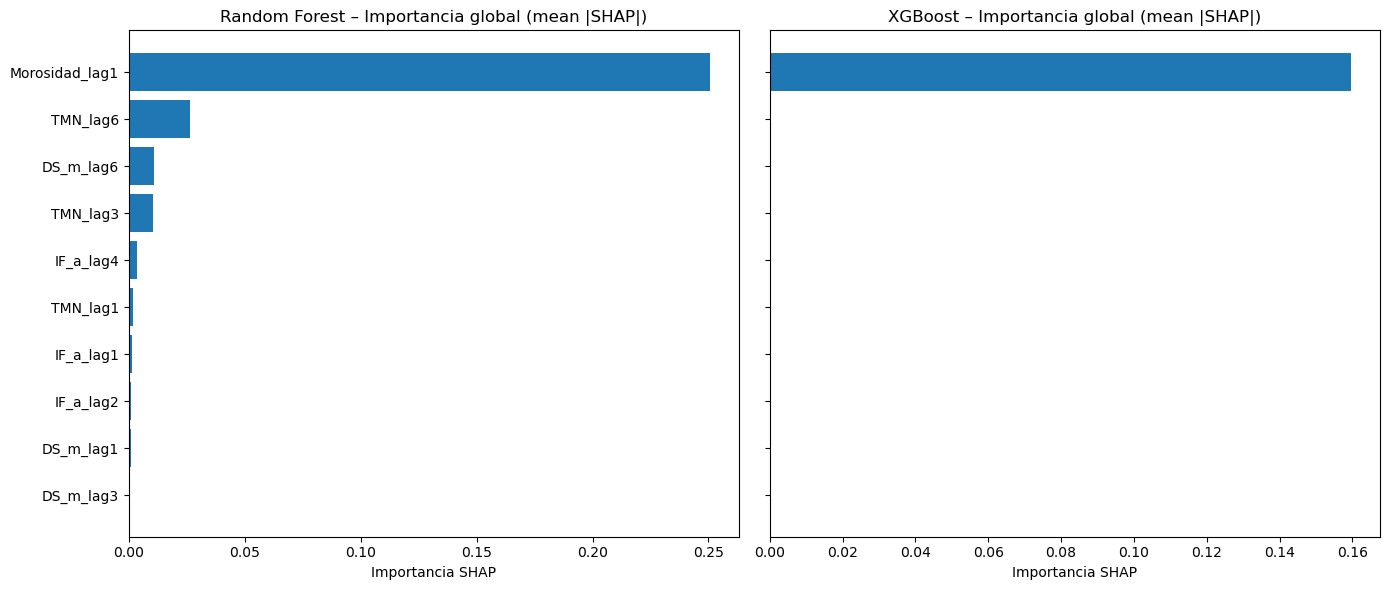

In [101]:


# Importancias ya calculadas
imp_rf = np.abs(shap_values_rf.values).mean(axis=0)
imp_xgb = np.abs(shap_values_xgb.values).mean(axis=0)

features = X_train_rf.columns

# Ordenar por importancia RF (más estable visualmente)
order = np.argsort(imp_rf)[::-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Random Forest ---
axes[0].barh(
    np.array(features)[order],
    imp_rf[order]
)
axes[0].set_title("Random Forest – Importancia global (mean |SHAP|)")
axes[0].invert_yaxis()
axes[0].set_xlabel("Importancia SHAP")

# --- XGBoost ---
axes[1].barh(
    np.array(features)[order],
    imp_xgb[order]
)
axes[1].set_title("XGBoost – Importancia global (mean |SHAP|)")
axes[1].set_xlabel("Importancia SHAP")

plt.tight_layout()
plt.show()


# Reestimación XGB sin Morosidad

In [96]:
# ============================================================
# REESTIMACIÓN RF y XGB SIN VARIABLE AUTOREGRESIVA
# ============================================================

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1. Quitar variable AR
# -----------------------------
auto_var = 'Morosidad_lag1'

X_train_xgb_noAR = X_train_xgb.drop(columns=[auto_var])
X_valid_xgb_noAR = X_valid_xgb.drop(columns=[auto_var])
X_test_xgb_noAR  = X_test_xgb.drop(columns=[auto_var])

X_train_rf_noAR = X_train_rf.drop(columns=[auto_var])
X_valid_rf_noAR = X_valid_rf.drop(columns=[auto_var])
X_test_rf_noAR  = X_test_rf.drop(columns=[auto_var])

# -----------------------------
# 2. XGBOOST sin AR (NumPy clean)
# -----------------------------
Xtr = np.asarray(X_train_xgb_noAR, dtype=np.float64)
ytr = np.asarray(y_train_xgb, dtype=np.float64)

Xva = np.asarray(X_valid_xgb_noAR, dtype=np.float64)
yva = np.asarray(y_valid_xgb, dtype=np.float64)

Xte = np.asarray(X_test_xgb_noAR, dtype=np.float64)
yte = np.asarray(y_test_xgb, dtype=np.float64)

xgb_noAR = XGBRegressor(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=0
)

xgb_noAR.fit(Xtr, ytr)

pred_valid_xgb_noAR = xgb_noAR.predict(Xva)
pred_test_xgb_noAR  = xgb_noAR.predict(Xte)

rmse_valid_xgb_noAR = mean_squared_error(yva, pred_valid_xgb_noAR, squared=False)
rmse_test_xgb_noAR  = mean_squared_error(yte, pred_test_xgb_noAR, squared=False)

# -----------------------------
# 3. RANDOM FOREST sin AR
# -----------------------------
rf_noAR = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=5,
    random_state=0
)

rf_noAR.fit(X_train_rf_noAR, y_train_rf)

pred_valid_rf_noAR = rf_noAR.predict(X_valid_rf_noAR)
pred_test_rf_noAR  = rf_noAR.predict(X_test_rf_noAR)

rmse_valid_rf_noAR = mean_squared_error(y_valid_rf, pred_valid_rf_noAR, squared=False)
rmse_test_rf_noAR  = mean_squared_error(y_test_rf, pred_test_rf_noAR, squared=False)

# -----------------------------
# 4. Tabla comparativa
# -----------------------------
comparison = pd.DataFrame({
    'Modelo': [
        'Random Forest (con AR)',
        'XGBoost (con AR)',
        'Random Forest (sin AR)',
        'XGBoost (sin AR)'
    ],
    'RMSE Valid': [
        rmse_valid_rf,
        rmse_valid_xgb,
        rmse_valid_rf_noAR,
        rmse_valid_xgb_noAR
    ],
    'RMSE Test': [
        rmse_test_rf,
        rmse_test_xgb,
        rmse_test_rf_noAR,
        rmse_test_xgb_noAR
    ]
})

comparison


C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

,Modelo,RMSE Valid,RMSE Test
0,Random Forest (con AR),0.207170,0.125220
1,XGBoost (con AR),0.191982,0.175387
2,Random Forest (sin AR),0.404000,0.335207
3,XGBoost (sin AR),0.460202,0.381624


# Real vs predicho

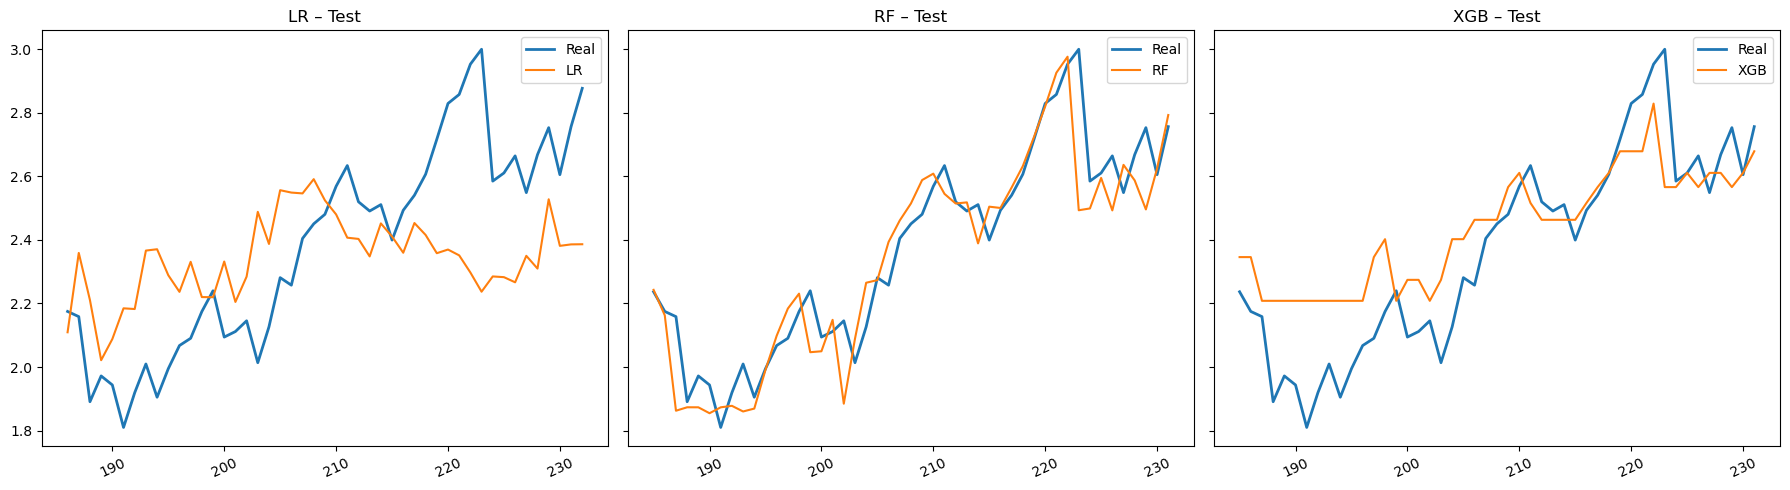

In [117]:
def plot_real_vs_pred_ax(dates, real, preds_dict, ax, title='Real vs Predicción'):
    ax.plot(dates, real, label='Real', linewidth=2)
    
    for name, pred in preds_dict.items():
        ax.plot(dates, pred, label=name)
    
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=25)
    ax.legend()
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

plot_real_vs_pred_ax(
    dates=X_test.index,
    real=y_test,
    preds_dict={'LR': pred_test},
    ax=axes[0],
    title='LR – Test'
)

plot_real_vs_pred_ax(
    dates=X_test_rf.index,
    real=y_test_rf,
    preds_dict={'RF': pred_test_rf},
    ax=axes[1],
    title='RF – Test'
)

plot_real_vs_pred_ax(
    dates=X_test_xgb.index,
    real=y_test_xgb,
    preds_dict={'XGB': pred_test_xgb},
    ax=axes[2],
    title='XGB – Test'
)

plt.tight_layout()
plt.show()

fig.savefig(
    "real_vs_pred_LR_RF_XGB.png",
    dpi=300,
    bbox_inches="tight"
)

# LIME (Local Interpretation)

C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


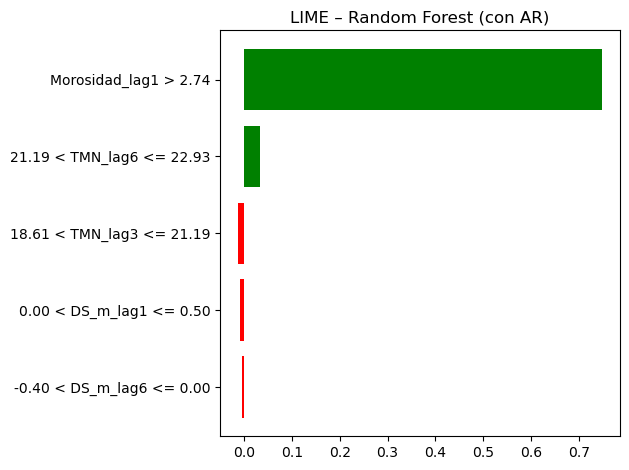

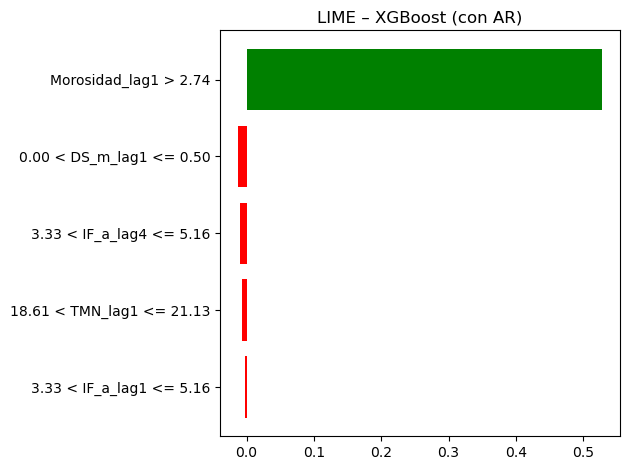

✔ LIME generado y guardado correctamente para RF y XGB (con AR)


In [103]:
# ===============================================================
# LIME – Explicabilidad local (RF y XGB CON AR)
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

# -----------------------------
# 1. Observación representativa
# -----------------------------
idx = 0  # índice del set de validación

# ===============================================================
# 2. LIME – RANDOM FOREST (con AR)
# ===============================================================
explainer_lime_rf = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_rf.values,
    feature_names=X_train_rf.columns,
    mode='regression',
    discretize_continuous=True,
    random_state=0
)

exp_rf = explainer_lime_rf.explain_instance(
    data_row=X_valid_rf.iloc[idx].values,
    predict_fn=opt_rf.predict,   # RF CON AR
    num_features=5
)

fig_rf = exp_rf.as_pyplot_figure()
plt.title("LIME – Random Forest (con AR)")
plt.tight_layout()
plt.savefig("lime_rf_con_AR.png", dpi=300, bbox_inches="tight")
plt.show()

# ===============================================================
# 3. LIME – XGBOOST (con AR)
# ===============================================================
explainer_lime_xgb = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_xgb.values,
    feature_names=X_train_xgb.columns,
    mode='regression',
    discretize_continuous=True,
    random_state=0
)

exp_xgb = explainer_lime_xgb.explain_instance(
    data_row=X_valid_xgb.iloc[idx].values,
    predict_fn=opt_xgb.predict,  # XGB CON AR
    num_features=5
)

fig_xgb = exp_xgb.as_pyplot_figure()
plt.title("LIME – XGBoost (con AR)")
plt.tight_layout()
plt.savefig("lime_xgb_con_AR.png", dpi=300, bbox_inches="tight")
plt.show()

print("✔ LIME generado y guardado correctamente para RF y XGB (con AR)")



C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


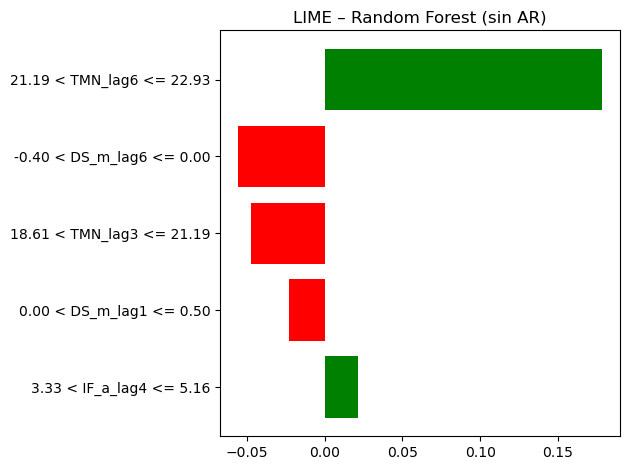

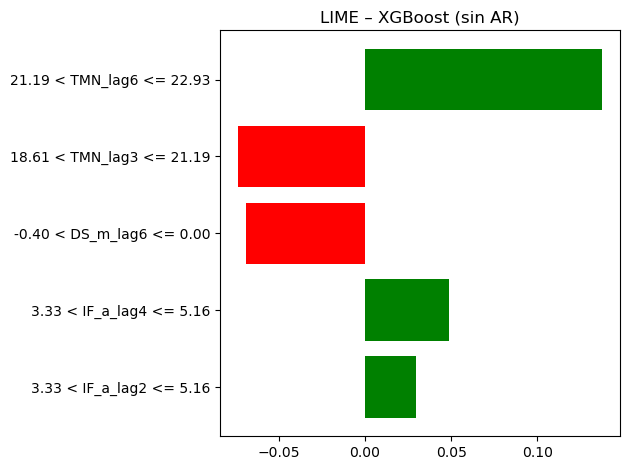

✔ LIME generado correctamente para RF y XGB (sin AR)


In [104]:
# ===============================================================
# LIME – Explicabilidad local (RF y XGB SIN AR)
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

# -----------------------------
# Observación representativa
# -----------------------------
idx = 0

# ===============================================================
# 1. RANDOM FOREST – SIN AR
# ===============================================================
explainer_lime_rf_noAR = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_rf_noAR.values,
    feature_names=X_train_rf_noAR.columns,
    mode='regression',
    discretize_continuous=True,
    random_state=0
)

exp_rf_noAR = explainer_lime_rf_noAR.explain_instance(
    data_row=X_valid_rf_noAR.iloc[idx].values,
    predict_fn=rf_noAR.predict,
    num_features=5
)

fig_rf_noAR = exp_rf_noAR.as_pyplot_figure()
plt.title("LIME – Random Forest (sin AR)")
plt.tight_layout()
plt.savefig("lime_rf_sin_AR.png", dpi=300, bbox_inches="tight")
plt.show()

# ===============================================================
# 2. XGBOOST – SIN AR
# ===============================================================
explainer_lime_xgb_noAR = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_xgb_noAR.values,
    feature_names=X_train_xgb_noAR.columns,
    mode='regression',
    discretize_continuous=True,
    random_state=0
)

exp_xgb_noAR = explainer_lime_xgb_noAR.explain_instance(
    data_row=X_valid_xgb_noAR.iloc[idx].values,
    predict_fn=xgb_noAR.predict,
    num_features=5
)

fig_xgb_noAR = exp_xgb_noAR.as_pyplot_figure()
plt.title("LIME – XGBoost (sin AR)")
plt.tight_layout()
plt.savefig("lime_xgb_sin_AR.png", dpi=300, bbox_inches="tight")
plt.show()

print("✔ LIME generado correctamente para RF y XGB (sin AR)")




In [105]:
from PIL import Image

# Cargar imágenes
img1 = Image.open("lime_rf_con_AR.png")
img2 = Image.open("lime_xgb_con_AR.png")
img3 = Image.open("lime_rf_sin_AR.png")
img4 = Image.open("lime_xgb_sin_AR.png")

# Asegurar mismo tamaño (opcional pero recomendado)
w, h = img1.size
img2 = img2.resize((w, h))
img3 = img3.resize((w, h))
img4 = img4.resize((w, h))

# Crear lienzo 2x2
combined = Image.new("RGB", (2*w, 2*h))

# Pegar imágenes
combined.paste(img1, (0, 0))
combined.paste(img2, (w, 0))
combined.paste(img3, (0, h))
combined.paste(img4, (w, h))

# Guardar
combined.save("lime_2x2.png", dpi=(300, 300))



# Visualización de residuos

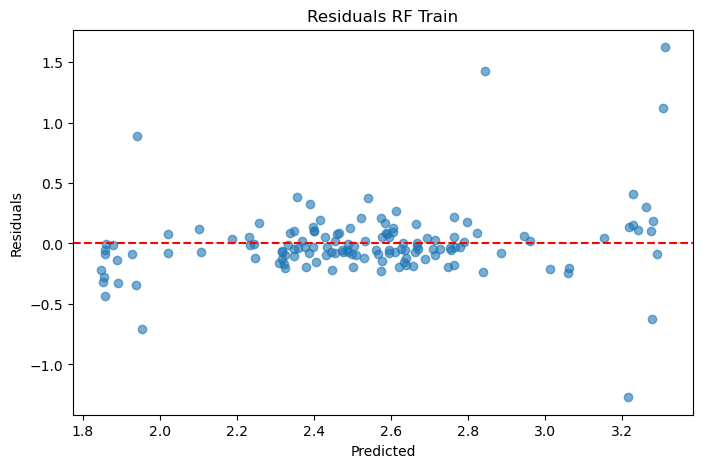

RMSE: 0.2959
R²:   0.6618


C:\Users\carol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [109]:
# ===============================================================
# 1️⃣ Visualización de residuos
# ===============================================================
def plot_residuals(model, X, y, title='Residuals'):
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.show()
    
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.4f}")
    print(f"R²:   {r2_score(y, y_pred):.4f}")

# Ejemplo
plot_residuals(opt_rf, X_train_xgb, y_train_xgb, title='Residuals RF Train')

# fidelidad (Yeh, et al., 2019) 

In [162]:
import numpy as np
import pandas as pd
import shap

# ===============================
# Función infidelity (robusta)
# ===============================
def infidelity(model, x, explanation, noise_std=0.01, n_samples=100):
    errors = []

    x = np.asarray(x, dtype=float)
    explanation = np.asarray(explanation, dtype=float)

    for _ in range(n_samples):
        delta = np.random.normal(0, noise_std, size=x.shape)

        fx = model.predict(x.reshape(1, -1))[0]
        fx_delta = model.predict((x - delta).reshape(1, -1))[0]

        approx_change = np.dot(explanation, delta)
        real_change = fx - fx_delta

        errors.append((real_change - approx_change) ** 2)

    return np.mean(errors)


# ===============================
# MODELOS
# ===============================
lr_model  = lr
rf_model  = opt_rf.best_estimator_
xgb_model = opt_xgb.best_estimator_


# ===============================
# DATOS (forzar float)
# ===============================
Xv_lr  = X_valid.astype(float)
Xv_rf  = X_valid_rf.astype(float)
Xv_xgb = X_valid_xgb.astype(float)

x_lr  = Xv_lr.iloc[0].values
x_rf  = Xv_rf.iloc[0].values
x_xgb = Xv_xgb.iloc[0].values


# ===============================
# EXPLICACIONES
# ===============================
# Regresión lineal → coeficientes
phi_lr = lr_model.coef_

# RF y XGB → SHAP model-agnostic con predict
expl_rf  = shap.Explainer(rf_model.predict,  Xv_rf)
expl_xgb = shap.Explainer(xgb_model.predict, Xv_xgb)

phi_rf  = expl_rf(Xv_rf).values[0]
phi_xgb = expl_xgb(Xv_xgb).values[0]


# ===============================
# INFIDELITY
# ===============================
inf_lr  = infidelity(lr_model,  x_lr,  phi_lr)
inf_rf  = infidelity(rf_model,  x_rf,  phi_rf)
inf_xgb = infidelity(xgb_model, x_xgb, phi_xgb)

ExactExplainer explainer: 47it [00:30,  1.06it/s]                                                                      
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with f

,Modelo,Infidelity
0,Regresión Lineal,3.393024e-32
1,Random Forest,1.209595e-06
2,XGBoost,1.560300e-07


In [164]:
# ===============================================================
# LIME – INFIDELITY para RF (sin discretización)
# ===============================================================
explainer_lime_rf_inf = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_rf.values,
    feature_names=X_train_rf.columns.tolist(),
    mode='regression',
    discretize_continuous=False,
    random_state=0
)

exp_rf_inf = explainer_lime_rf_inf.explain_instance(
    data_row=X_valid_rf.iloc[idx].values,
    predict_fn=opt_rf.predict,
    num_features=X_train_rf.shape[1]
)

# Vector completo de pesos
lime_weights_rf = np.zeros(X_train_rf.shape[1])

for feat, weight in exp_rf_inf.as_list():
    idx_feat = X_train_rf.columns.tolist().index(feat)
    lime_weights_rf[idx_feat] = weight

# Infidelity
x = X_valid_rf.iloc[idx].values
infid_lime_rf = infidelity(opt_rf, x, lime_weights_rf)


# ===============================================================
# LIME – INFIDELITY para XGB
# ===============================================================
explainer_lime_xgb_inf = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_xgb.values,
    feature_names=X_train_xgb.columns.tolist(),
    mode='regression',
    discretize_continuous=False,
    random_state=0
)

exp_xgb_inf = explainer_lime_xgb_inf.explain_instance(
    data_row=X_valid_xgb.iloc[idx].values,
    predict_fn=opt_xgb.predict,
    num_features=X_train_xgb.shape[1]
)

lime_weights_xgb = np.zeros(X_train_xgb.shape[1])

for feat, weight in exp_xgb_inf.as_list():
    idx_feat = X_train_xgb.columns.tolist().index(feat)
    lime_weights_xgb[idx_feat] = weight

x = X_valid_xgb.iloc[idx].values
infid_lime_xgb = infidelity(opt_xgb, x, lime_weights_xgb)

df_infidelity = pd.DataFrame({
    "Modelo": ["Regresión Lineal", "Random Forest", "XGBoost"],
    "Infidelity SHAP": [inf_lr, inf_rf, inf_xgb],
    "Infidelity LIME": [np.nan, infid_lime_rf, infid_lime_xgb]
})

df_infidelity


C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: U

,Modelo,Infidelity SHAP,Infidelity LIME
0,Regresión Lineal,3.393024e-32,NaN
1,Random Forest,1.209595e-06,0.000011
2,XGBoost,1.560300e-07,0.000006


# estabilidad (Yeh, et al., 2019)

In [168]:
import numpy as np

# -------------------------------------------------
# Sensitivity / Stability (Yeh et al., 2019)
# -------------------------------------------------
def sensitivity(explainer_fn, model, x, noise_std=0.01, n_samples=50):
    base_expl = explainer_fn(model, x)
    diffs = []

    for _ in range(n_samples):
        delta = np.random.normal(0, noise_std, size=x.shape)
        expl_pert = explainer_fn(model, x + delta)
        diffs.append(np.linalg.norm(expl_pert - base_expl))

    return np.mean(diffs)


# -------------------------------------------------
# SHAP explainer function (MODEL + X CORRECTO)
# -------------------------------------------------
def shap_explainer_fn(model, x):
    explainer = shap.Explainer(model.predict, X_train_rf)
    shap_vals = explainer(x.reshape(1, -1))
    return shap_vals.values.flatten()


# -------------------------------------------------
# Observación coherente con el modelo
# -------------------------------------------------
x = X_valid_rf.iloc[0].values

# -------------------------------------------------
# Stability SHAP – Random Forest
# -------------------------------------------------
stability_shap_rf = sensitivity(shap_explainer_fn, opt_rf, x)

stability_shap_rf


0.0011145799935854107

In [169]:
def lime_explainer_fn(model, x):
    exp = explainer_lime_rf_inf.explain_instance(
        x,
        model.predict,
        num_features=X_train_rf.shape[1]
    )
    weights = np.zeros(X_train_rf.shape[1])
    for feat, w in exp.as_list():
        idx = X_train_rf.columns.tolist().index(feat)
        weights[idx] = w
    return weights


stability_lime_rf = sensitivity(lime_explainer_fn, opt_rf, x)

stability_lime_rf


C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\carol\anaconda3\Lib\site-packages\sklearn\base.py:493: U

0.006729197310413001

In [172]:
# -------------------------------------------------
# Stability SHAP – XGBoost
# -------------------------------------------------
def shap_explainer_fn_xgb(model, x):
    explainer = shap.Explainer(model.predict, X_train_xgb)
    shap_vals = explainer(x.reshape(1, -1))
    return shap_vals.values.flatten()


x_xgb = X_valid_xgb.iloc[0].values

stability_shap_xgb = sensitivity(
    shap_explainer_fn_xgb,
    opt_xgb,
    x_xgb
)

stability_shap_xgb


0.0

In [173]:
# -------------------------------------------------
# LIME explainer function – XGBoost
# -------------------------------------------------
def lime_explainer_fn_xgb(model, x):
    exp = explainer_lime_xgb_inf.explain_instance(
        x,
        model.predict,
        num_features=X_train_xgb.shape[1]
    )
    weights = np.zeros(X_train_xgb.shape[1])
    for feat, w in exp.as_list():
        idx = X_train_xgb.columns.tolist().index(feat)
        weights[idx] = w
    return weights


stability_lime_xgb = sensitivity(
    lime_explainer_fn_xgb,
    opt_xgb,
    x_xgb
)

stability_lime_xgb


0.0038262839380006947

In [174]:
df_stability = pd.DataFrame({
    "Modelo": ["Random Forest", "XGBoost"],
    "Stability SHAP": [stability_shap_rf, stability_shap_xgb],
    "Stability LIME": [stability_lime_rf, stability_lime_xgb]
})

df_stability


,Modelo,Stability SHAP,Stability LIME
0,Random Forest,0.001115,0.006729
1,XGBoost,0.000000,0.003826
